In [23]:
#Volcanic rocks classification with Densenet121 and Resnet50
# Written by Ozlem Polat 2020

import keras
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.preprocessing import image
from keras.callbacks import TensorBoard 
from keras.utils.data_utils import get_file
from tensorflow.keras.applications import ResNet50, DenseNet121
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Input, Dropout, Activation, Flatten, BatchNormalization,ZeroPadding2D,concatenate,Lambda,GlobalAveragePooling2D
from keras.optimizers import Adam,SGD,RMSprop, Adadelta
import os
import random
import numpy as np
from skimage import io
import cv2 
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, confusion_matrix,classification_report 
from scipy import interp
from itertools import cycle
from tqdm import tqdm


In [ ]:
!nvidia-smi

Wed Apr 28 22:00:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    19W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pwd

/home/jupyter


In [ ]:
!ls "../ychen/COMP551/mini4_data/volkanik_kayac"

andezit  bazalt  dasit	latit  riyolit	trakit


In [ ]:


#rock_classes = ['andesite', 'basalt', 'dacite', 'latite', 'rhyolite', 'trachyte']
rock_classes = ['andezit', 'bazalt', 'dasit', 'latit', 'riyolit', 'trakit']

height=224 
width=224

train_ratio=0.7
test_ratio=0.3
class_number=6

dataset_path= "../ychen/COMP551/mini4_data/volkanik_kayac"
X_train=[]
y_train=[]
X_test=[]
y_test=[]
for cls in rock_classes:
  
  img_path=os.path.join(dataset_path,cls)
  img_files=os.listdir(img_path)
  train_number=round(len(img_files)*train_ratio)
  test_number=round(len(img_files)*test_ratio)
  print("\nTrain data= ",train_number,"\ntest data= ",test_number)
  
  #creating train images
 
  for i in tqdm(range(train_number)):

    a=random.choice(img_files)
    
    img_files=np.delete(img_files,np.argwhere(img_files==a))
    
    img_f=os.path.join(img_path,a)
    img=cv2.imread(img_f)

    img=cv2.resize(img,(height,width))  
    img =img.astype(np.float32) / img.max()  
    img=image.img_to_array(img) 
    img = img.reshape((1,) + img.shape)       
    X_train.append(img) 
    y_train.append(rock_classes.index(cls))
    img_files=np.delete(img_files,np.argwhere(img_files==a))
 
  #creating test images
  for j in tqdm(img_files):
        
    v=os.path.join(img_path,j)
    
    img=cv2.imread(v)

    img=cv2.resize(img,(height,width))  
    img =img.astype(np.float32) / img.max()  
    img=image.img_to_array(img) 
    img = img.reshape((1,) + img.shape)       
    X_test.append(img) 
    y_test.append(rock_classes.index(cls))


 17%|█▋        | 24/140 [00:00<00:00, 237.64it/s]


Train data=  140 
test data=  60


 22%|██▏       | 31/140 [00:00<00:00, 304.94it/s]


Train data=  140 
test data=  60


 24%|██▍       | 34/140 [00:00<00:00, 337.63it/s]


Train data=  140 
test data=  60


 24%|██▍       | 34/140 [00:00<00:00, 339.15it/s]


Train data=  140 
test data=  60


 24%|██▎       | 33/140 [00:00<00:00, 324.35it/s]


Train data=  140 
test data=  60


 24%|██▍       | 34/140 [00:00<00:00, 335.16it/s]


Train data=  140 
test data=  60


100%|██████████| 60/60 [00:00<00:00, 343.28it/s]


In [24]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

840 840
360 360


In [ ]:
def make_report(ii=0):
    matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    print(matrix)
    cr = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=rock_classes)
    cm = np.array2string(matrix)
    f = open(os.path.join(save_path,"report_"+str(ii)+".txt"), 'w')
    f.write('Volcanic Rock \nClassification Report\n\n{}\n\nConfusion Matrix\n\n{}\n'.format(cr, cm))
    f.close()


In [ ]:
def plot_roc(ii=0):

    # Plot linewidth.
    lw = 2
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(class_number):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_number)]))

    # interpolate all ROC curves 
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(class_number):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # compute AUC
    mean_tpr /= class_number

    # Plot all ROC curves
    plt.close("all")
    all_plt=plt.figure(1)

    colors = cycle(["blue","red", "purple", "gray", "pink", "brown"])
    for i, color in zip(range(class_number), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='{0} (area = {1:0.3f})'
                 ''.format(rock_classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves of volcanic rock classes')
    plt.legend(loc="lower right")
    all_plt.savefig(save_path+"all_auc_"+str(ii)+".jpg",dpi=150)
    plt.show()


In [ ]:
X_train=np.array(X_train,dtype=np.float32)
X_train = X_train.reshape(X_train.shape[0], height, width, 3)

X_test=np.array(X_test,dtype=np.float32)
X_test = X_test.reshape(X_test.shape[0], height, width, 3)

y_train = np.array(y_train, dtype=np.float32)
y_train = keras.utils.to_categorical(y_train, class_number)

y_test = np.array(y_test, dtype=np.float32)
y_test = keras.utils.to_categorical(y_test, class_number)


Vanilla DenseNet with ADAM optimizer

In [ ]:
# Cloud VM

save_path="../ychen/COMP551/mini4_data/classification_results/ADAM_Vanilla_DenseNet/"
print(os.path.isdir(save_path))
if os.path.isdir(save_path)==True:
  print("directory exists")
else:
  os.mkdir(save_path)
  print("new directory was created")

False
new directory was created


fold: 0
Epoch 1/50
53/53 [==============================] - 51s 228ms/step - loss: 1.6151 - accuracy: 0.4936
Epoch 2/50
53/53 [==============================] - 10s 184ms/step - loss: 0.0523 - accuracy: 0.9803
Epoch 3/50
53/53 [==============================] - 10s 186ms/step - loss: 0.0071 - accuracy: 1.0000
Epoch 4/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0101 - accuracy: 1.0000
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 6/50
53/53 [==============================] - 10s 193ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 7/50
53/53 [==============================] - 10s 192ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 8/50
53/53 [==============================] - 10s 190ms/step - loss: 0.0078 - accuracy: 0.9991
Epoch 9/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 10/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0020 

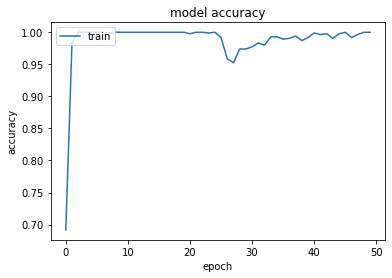

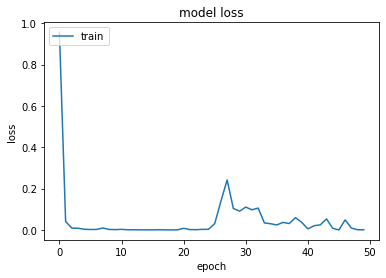

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


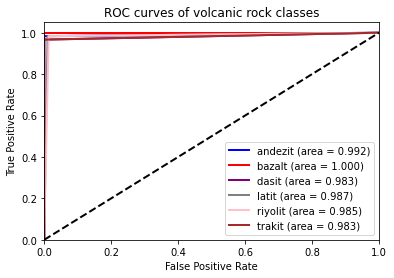

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 58  0  2  0]
 [ 0  0  0 59  1  0]
 [ 0  0  0  1 59  0]
 [ 0  0  0  2  0 58]]
fold: 1
Epoch 1/50
53/53 [==============================] - 19s 188ms/step - loss: 3.0073 - accuracy: 0.5532
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 0.4969 - accuracy: 0.9131
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 0.1456 - accuracy: 0.9746
Epoch 4/50
53/53 [==============================] - 10s 193ms/step - loss: 0.1262 - accuracy: 0.9743
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 0.1270 - accuracy: 0.9751
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.1100 - accuracy: 0.9782
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0525 - accuracy: 0.9887
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0218 - accuracy: 0.9940
Epoch 9/50
53/53 [==============================] - 10s 1

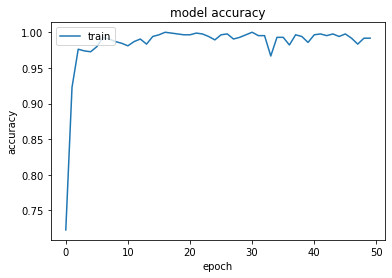

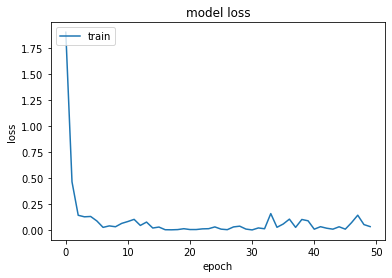

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


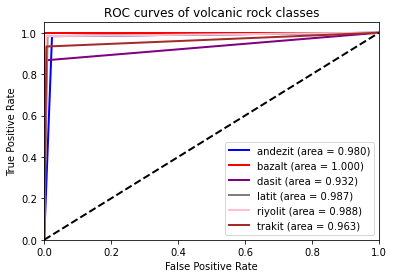

[[59  0  0  1  0  0]
 [ 0 60  0  0  0  0]
 [ 7  0 52  0  0  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 59  1]
 [ 0  0  1  2  1 56]]
fold: 2
Epoch 1/50
53/53 [==============================] - 19s 188ms/step - loss: 2.5443 - accuracy: 0.5563
Epoch 2/50
53/53 [==============================] - 10s 190ms/step - loss: 1.1045 - accuracy: 0.8743
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 0.5765 - accuracy: 0.9108
Epoch 4/50
53/53 [==============================] - 10s 193ms/step - loss: 0.2366 - accuracy: 0.9444
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 0.0777 - accuracy: 0.9838
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.1858 - accuracy: 0.9650
Epoch 7/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0885 - accuracy: 0.9743
Epoch 8/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0248 - accuracy: 0.9905
Epoch 9/50
53/53 [==============================] - 10s 1

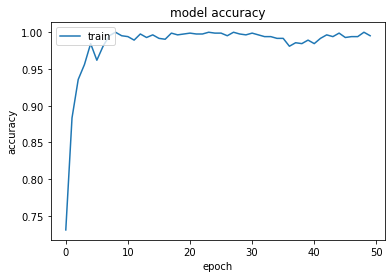

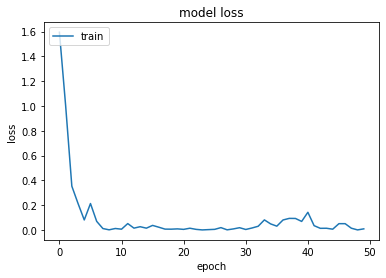

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


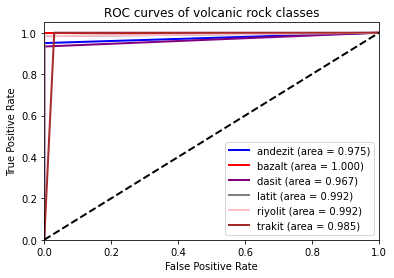

[[57  0  0  0  0  3]
 [ 0 60  0  0  0  0]
 [ 0  0 56  0  0  4]
 [ 0  0  0 59  0  1]
 [ 0  0  0  0 59  1]
 [ 0  0  0  0  0 60]]
fold: 3
Epoch 1/50
53/53 [==============================] - 19s 188ms/step - loss: 2.3085 - accuracy: 0.5385
Epoch 2/50
53/53 [==============================] - 10s 190ms/step - loss: 0.4482 - accuracy: 0.9205
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 0.2969 - accuracy: 0.9511
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.2119 - accuracy: 0.9653
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 0.1850 - accuracy: 0.9712
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.0929 - accuracy: 0.9876
Epoch 7/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0173 - accuracy: 0.9956
Epoch 8/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0179 - accuracy: 0.9978
Epoch 9/50
53/53 [==============================] - 10s 1

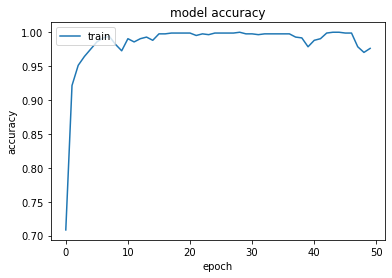

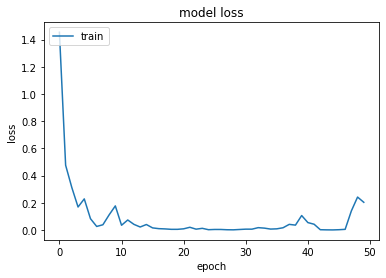

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


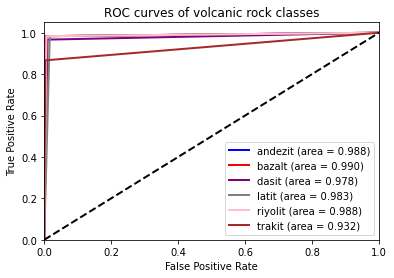

[[59  0  0  0  1  0]
 [ 1 59  0  0  0  0]
 [ 0  1 58  0  0  1]
 [ 0  0  0 59  1  0]
 [ 0  0  1  0 59  0]
 [ 1  0  2  5  0 52]]
fold: 4
Epoch 1/50
53/53 [==============================] - 20s 189ms/step - loss: 2.9747 - accuracy: 0.5267
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 0.5530 - accuracy: 0.9083
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 0.1271 - accuracy: 0.9625
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.4805 - accuracy: 0.9497
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.0626 - accuracy: 0.9806
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.1568 - accuracy: 0.9688
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0347 - accuracy: 0.9892
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0164 - accuracy: 0.9959
Epoch 9/50
53/53 [==============================] - 10s 1

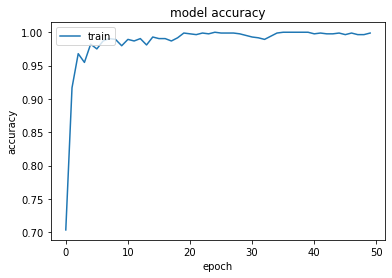

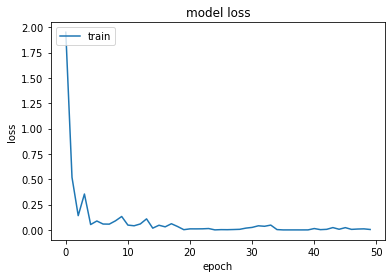

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


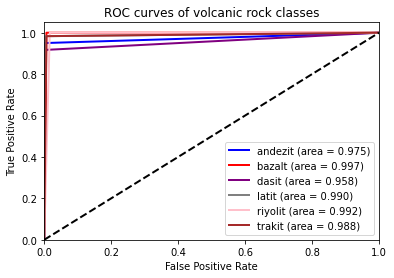

[[57  2  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 55  0  3  2]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  1  0 59]]
fold: 5
Epoch 1/50
53/53 [==============================] - 19s 188ms/step - loss: 2.8577 - accuracy: 0.5713
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 0.7485 - accuracy: 0.8833
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 0.2439 - accuracy: 0.9622
Epoch 4/50
53/53 [==============================] - 10s 193ms/step - loss: 0.2761 - accuracy: 0.9532
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 0.1018 - accuracy: 0.9671
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.0303 - accuracy: 0.9914
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0690 - accuracy: 0.9901
Epoch 8/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0679 - accuracy: 0.9843
Epoch 9/50
53/53 [==============================] - 10s 1

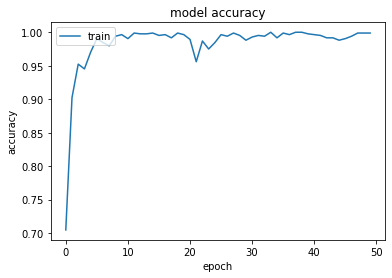

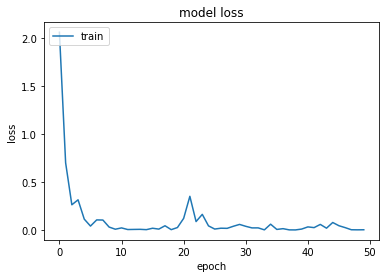

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


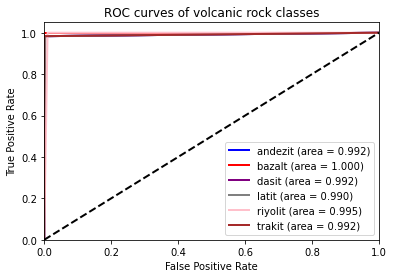

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 59  0  1  0]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  1  0 59]]

number of folds: 6
average test accuracies: 1


In [ ]:
#Training Process

EPOCHS=50
BATCH_SIZE=16
x_fold=6
#optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-07, decay=0.0)
optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
#optimizer=SGD(lr=0.001, momentum=0.0, nesterov=False)
#optimizer=RMSprop(lr=0.0001, rho=0.9)

metric="accuracy" 
loss="categorical_crossentropy" 
model_checkpoint_callback=keras.callbacks.ModelCheckpoint("bestmodel.h5",save_best_only=True,save_weights_only=True,)
callbacks=[model_checkpoint_callback]

test_accuracies = []

for i in range(x_fold):
  print("fold:", i)
  input_shape=(height, width, 3)
  Transfer_Model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
  #Transfer_Model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
  
  add_model = Sequential()

  add_model.add(Flatten())
  # add_model.add(BatchNormalization())
  # add_model.add(Dense(16, activation='relu'))
  # add_model.add(Dropout(0.25))
  # add_model.add(BatchNormalization())
        
  add_model.add(Dense(class_number, activation='softmax'))
  #add_model.add(Tranfer_Model.output)

  model = Model(inputs=Transfer_Model.input, outputs=add_model(Transfer_Model.output))

  model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
  history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
  #predictions
  y_pred= model.predict(X_test)
  y_pred=np.argmax(y_pred,axis=1).astype(np.float32)
  y_pred = keras.utils.to_categorical(y_pred, class_number)

  train_score = model.evaluate(X_train, y_train)
  test_score = model.evaluate(X_test, y_test)
  print(train_score)
  print(test_score)
  test_accuracies.append(test_score[1])

  #Plot accuracy 
  plt.close("all")
  plt.plot(history.history['accuracy'])
  #plt.plot(history.history['val_accuracy'])  
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"acc_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot loss
  plt.close("all")
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_accuracy'])
      
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"loss_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot ROC
  plot_roc(i)
  make_report(i)

print("")
print("number of folds:", i+1)
print("average test accuracies:", round(sum(test_accuracies)/len(test_accuracies), 3))

# 52m59s

In [ ]:
print("number of folds:", i+1)
print("average test accuracies:", round(sum(test_accuracies)/len(test_accuracies), 3))

number of folds: 6
average test accuracies: 0.973


Vanilla DenseNet with RMSprop optimizer

In [ ]:
save_path="../ychen/COMP551/mini4_data/classification_results/RMSprop_Vanilla_DenseNet/"
print(os.path.isdir(save_path))
if os.path.isdir(save_path)==True:
  print("directory exists")
else:
  os.mkdir(save_path)
  print("new directory was created")

False
new directory was created


In [ ]:
print(save_path)

../ychen/COMP551/mini4_data/classification_results/RMSprop_Vanilla_DenseNet/


fold: 0
Epoch 1/50
53/53 [==============================] - 27s 201ms/step - loss: 1.9395 - accuracy: 0.4793
Epoch 2/50
53/53 [==============================] - 11s 203ms/step - loss: 0.0427 - accuracy: 0.9844
Epoch 3/50
53/53 [==============================] - 11s 201ms/step - loss: 0.0382 - accuracy: 0.9836
Epoch 4/50
53/53 [==============================] - 11s 199ms/step - loss: 0.0219 - accuracy: 0.9930
Epoch 5/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0100 - accuracy: 0.9936
Epoch 6/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0075 - accuracy: 1.0000
Epoch 7/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0066 - accuracy: 0.9977
Epoch 8/50
53/53 [==============================] - 10s 198ms/step - loss: 0.0137 - accuracy: 0.9978
Epoch 9/50
53/53 [==============================] - 11s 199ms/step - loss: 0.0310 - accuracy: 0.9927
Epoch 10/50
53/53 [==============================] - 11s 199ms/step - loss: 0.0029 

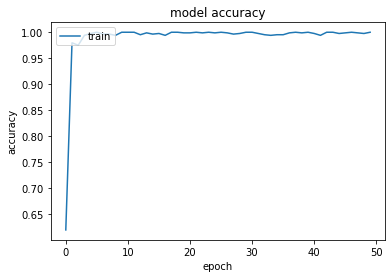

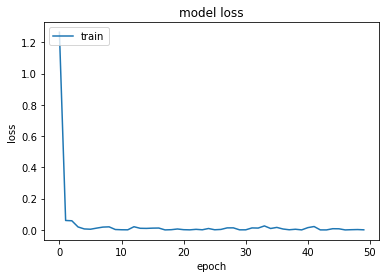

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


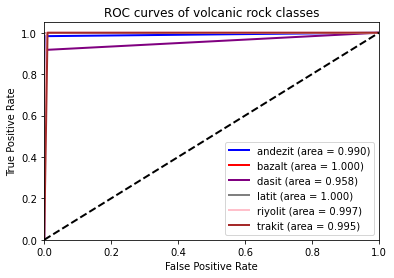

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 1  0 55  0  1  3]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 1
Epoch 1/50
53/53 [==============================] - 26s 197ms/step - loss: 2.0249 - accuracy: 0.4944
Epoch 2/50
53/53 [==============================] - 11s 201ms/step - loss: 0.0543 - accuracy: 0.9774
Epoch 3/50
53/53 [==============================] - 11s 204ms/step - loss: 0.0271 - accuracy: 0.9906
Epoch 4/50
53/53 [==============================] - 11s 204ms/step - loss: 0.0259 - accuracy: 0.9926
Epoch 5/50
53/53 [==============================] - 11s 200ms/step - loss: 0.0067 - accuracy: 0.9966
Epoch 6/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0128 - accuracy: 0.9979
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0019 - accuracy: 0.9997
Epoch 8/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0043 - accuracy: 0.9996
Epoch 9/50
53/53 [==============================] - 10s 1

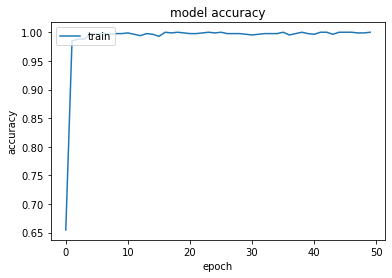

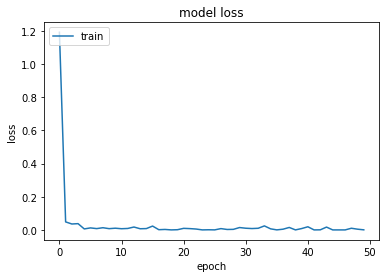

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


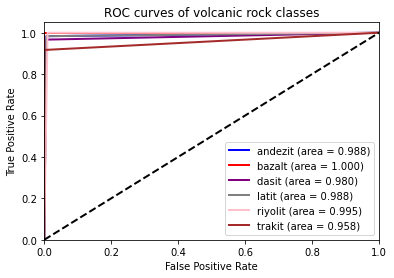

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 2  0 58  0  0  0]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  2  2  1 55]]
fold: 2
Epoch 1/50
53/53 [==============================] - 26s 197ms/step - loss: 2.0690 - accuracy: 0.4648
Epoch 2/50
53/53 [==============================] - 11s 201ms/step - loss: 0.0386 - accuracy: 0.9853
Epoch 3/50
53/53 [==============================] - 11s 204ms/step - loss: 0.0294 - accuracy: 0.9859
Epoch 4/50
53/53 [==============================] - 11s 202ms/step - loss: 0.0167 - accuracy: 0.9916
Epoch 5/50
53/53 [==============================] - 11s 198ms/step - loss: 0.0457 - accuracy: 0.9839
Epoch 6/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0461 - accuracy: 0.9860
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0163 - accuracy: 0.9966
Epoch 8/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0029 - accuracy: 0.9996
Epoch 9/50
53/53 [==============================] - 11s 1

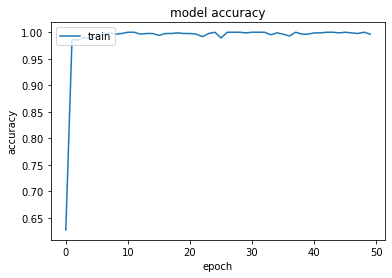

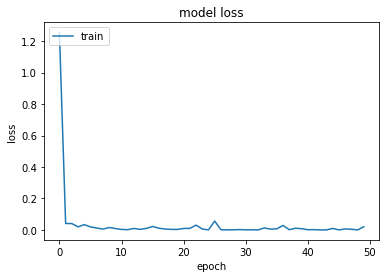

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


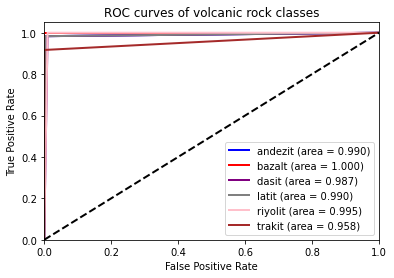

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 1  0 59  0  0  0]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  3  1  1 55]]
fold: 3
Epoch 1/50
53/53 [==============================] - 26s 196ms/step - loss: 1.9725 - accuracy: 0.4837
Epoch 2/50
53/53 [==============================] - 11s 200ms/step - loss: 0.0427 - accuracy: 0.9864
Epoch 3/50
53/53 [==============================] - 11s 201ms/step - loss: 0.0204 - accuracy: 0.9948
Epoch 4/50
53/53 [==============================] - 11s 201ms/step - loss: 0.0131 - accuracy: 0.9969
Epoch 5/50
53/53 [==============================] - 11s 199ms/step - loss: 0.0106 - accuracy: 0.9972
Epoch 6/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0103 - accuracy: 0.9982
Epoch 7/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0114 - accuracy: 0.9976
Epoch 8/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0396 - accuracy: 0.9859
Epoch 9/50
53/53 [==============================] - 11s 2

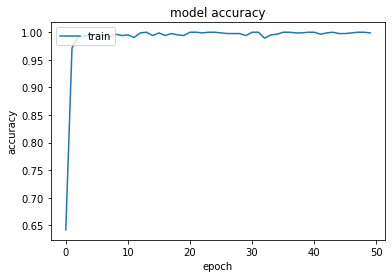

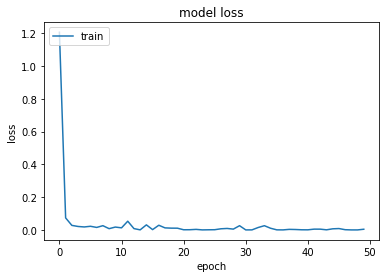

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


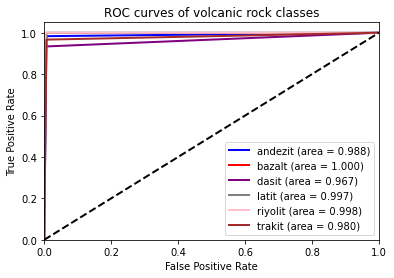

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 2  0 56  0  0  2]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  2  0 58]]
fold: 4
Epoch 1/50
53/53 [==============================] - 26s 196ms/step - loss: 2.0607 - accuracy: 0.5039
Epoch 2/50
53/53 [==============================] - 11s 199ms/step - loss: 0.0432 - accuracy: 0.9851
Epoch 3/50
53/53 [==============================] - 11s 201ms/step - loss: 0.0490 - accuracy: 0.9858
Epoch 4/50
53/53 [==============================] - 11s 201ms/step - loss: 0.0114 - accuracy: 1.0000
Epoch 5/50
53/53 [==============================] - 11s 198ms/step - loss: 0.0301 - accuracy: 0.9777
Epoch 6/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0051 - accuracy: 0.9976
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0098 - accuracy: 0.9955
Epoch 8/50
53/53 [==============================] - 10s 195ms/step - loss: 0.0147 - accuracy: 0.9959
Epoch 9/50
53/53 [==============================] - 10s 1

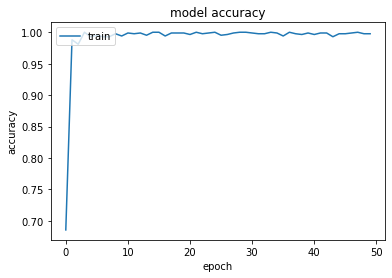

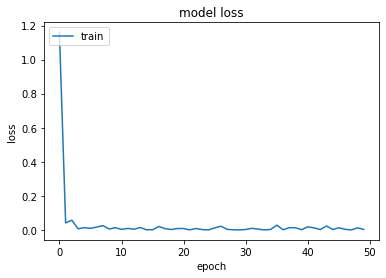

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


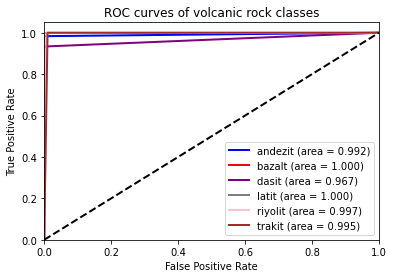

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 56  0  1  3]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 5
Epoch 1/50
53/53 [==============================] - 27s 198ms/step - loss: 2.0934 - accuracy: 0.5085
Epoch 2/50
53/53 [==============================] - 11s 200ms/step - loss: 0.0776 - accuracy: 0.9827
Epoch 3/50
53/53 [==============================] - 11s 203ms/step - loss: 0.0217 - accuracy: 0.9959
Epoch 4/50
53/53 [==============================] - 11s 202ms/step - loss: 0.0203 - accuracy: 0.9966
Epoch 5/50
53/53 [==============================] - 11s 199ms/step - loss: 0.0568 - accuracy: 0.9897
Epoch 6/50
53/53 [==============================] - 10s 198ms/step - loss: 0.0223 - accuracy: 0.9932
Epoch 7/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0157 - accuracy: 0.9920
Epoch 8/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0017 - accuracy: 0.9999
Epoch 9/50
53/53 [==============================] - 10s 1

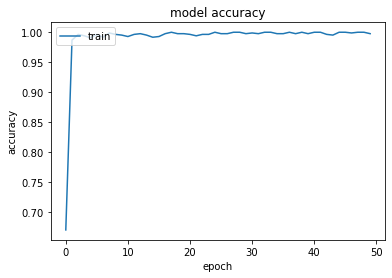

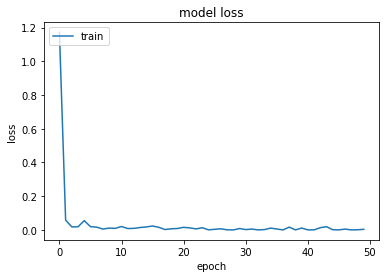

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


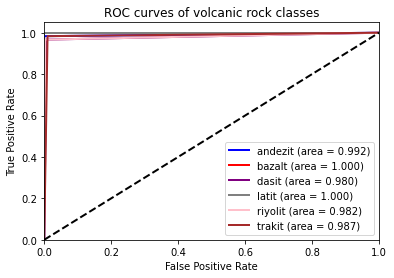

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 58  0  0  2]
 [ 0  0  0 60  0  0]
 [ 0  0  1  0 58  1]
 [ 0  0  1  0  0 59]]

number of folds: 6
average test accuracies: 0.981


In [ ]:
#Training Process

EPOCHS=50
BATCH_SIZE=16
x_fold=6
#optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-07, decay=0.0)
#optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
#optimizer=SGD(lr=0.001, momentum=0.0, nesterov=False)
optimizer=RMSprop(lr=0.0001, rho=0.9)

metric="accuracy" 
loss="categorical_crossentropy" 
model_checkpoint_callback=keras.callbacks.ModelCheckpoint("bestmodel.h5",save_best_only=True,save_weights_only=True,)
callbacks=[model_checkpoint_callback]

test_accuracies = []

for i in range(x_fold):
  print("fold:", i)
  input_shape=(height, width, 3)
  Transfer_Model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
  #Transfer_Model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
  
  add_model = Sequential()

  add_model.add(Flatten())
  # add_model.add(BatchNormalization())
  # add_model.add(Dense(16, activation='relu'))
  # add_model.add(Dropout(0.25))
  # add_model.add(BatchNormalization())
        
  add_model.add(Dense(class_number, activation='softmax'))
  #add_model.add(Tranfer_Model.output)

  model = Model(inputs=Transfer_Model.input, outputs=add_model(Transfer_Model.output))

  model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
  history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
  #predictions
  y_pred= model.predict(X_test)
  y_pred=np.argmax(y_pred,axis=1).astype(np.float32)
  y_pred = keras.utils.to_categorical(y_pred, class_number)

  train_score = model.evaluate(X_train, y_train)
  test_score = model.evaluate(X_test, y_test)
  print(train_score)
  print(test_score)
  test_accuracies.append(test_score[1])

  #Plot accuracy 
  plt.close("all")
  plt.plot(history.history['accuracy'])
  #plt.plot(history.history['val_accuracy'])  
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"acc_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot loss
  plt.close("all")
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_accuracy'])
      
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"loss_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot ROC
  plot_roc(i)
  make_report(i)

print("")
print("number of folds:", i+1)
print("average test accuracies:", round(sum(test_accuracies)/len(test_accuracies), 3))

DenseNet121 with ADAM optimizer, reduced dense layer in add_model

In [ ]:
save_path="../ychen/COMP551/mini4_data/classification_results/DenseNet121_ADAM_reducedDense/"
print(os.path.isdir(save_path))
if os.path.isdir(save_path)==True:
  print("directory exists")
else:
  os.mkdir(save_path)
  print("new directory was created")

False
new directory was created


In [ ]:
print(save_path)

../ychen/COMP551/mini4_data/classification_results/DenseNet121_ADAM_reducedDense/


fold: 0
Epoch 1/50
53/53 [==============================] - 20s 190ms/step - loss: 1.7104 - accuracy: 0.3466
Epoch 2/50
53/53 [==============================] - 10s 193ms/step - loss: 0.8843 - accuracy: 0.7103
Epoch 3/50
53/53 [==============================] - 10s 195ms/step - loss: 0.7400 - accuracy: 0.7957
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.7104 - accuracy: 0.8215
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 0.6703 - accuracy: 0.8256
Epoch 6/50
53/53 [==============================] - 10s 189ms/step - loss: 0.6095 - accuracy: 0.8704
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.5925 - accuracy: 0.8599
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 0.6230 - accuracy: 0.8479
Epoch 9/50
53/53 [==============================] - 10s 189ms/step - loss: 0.5846 - accuracy: 0.8608
Epoch 10/50
53/53 [==============================] - 10s 190ms/step - loss: 0.5823 

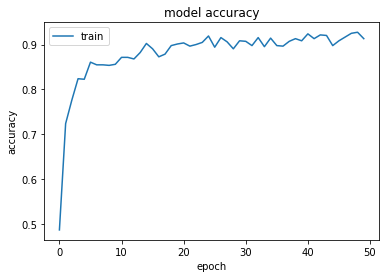

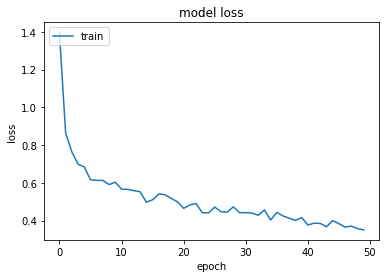

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


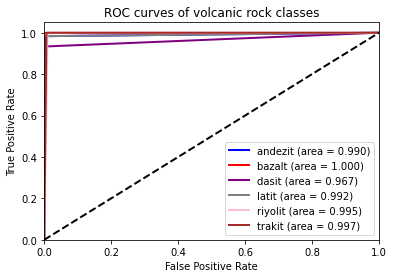

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 1  0 56  0  1  2]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 1
Epoch 1/50
53/53 [==============================] - 20s 189ms/step - loss: 1.2552 - accuracy: 0.5422
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 0.7134 - accuracy: 0.8180
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 0.6332 - accuracy: 0.8708
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.6010 - accuracy: 0.8765
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.5808 - accuracy: 0.8833
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.5463 - accuracy: 0.8910
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.5367 - accuracy: 0.8767
Epoch 8/50
53/53 [==============================] - 10s 188ms/step - loss: 0.5678 - accuracy: 0.8598
Epoch 9/50
53/53 [==============================] - 10s 1

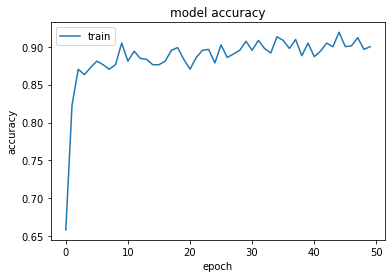

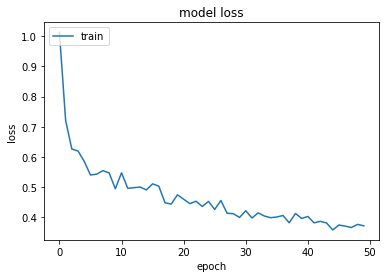

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


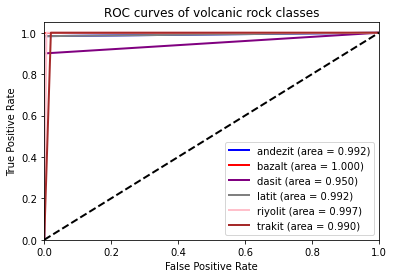

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 54  0  0  6]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 2
Epoch 1/50
53/53 [==============================] - 20s 188ms/step - loss: 1.3317 - accuracy: 0.5124
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 0.7649 - accuracy: 0.7886
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 0.7023 - accuracy: 0.8108
Epoch 4/50
53/53 [==============================] - 10s 193ms/step - loss: 0.6612 - accuracy: 0.8539
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 0.6355 - accuracy: 0.8488
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.5743 - accuracy: 0.8645
Epoch 7/50
53/53 [==============================] - 10s 188ms/step - loss: 0.5369 - accuracy: 0.8683
Epoch 8/50
53/53 [==============================] - 10s 188ms/step - loss: 0.5406 - accuracy: 0.8965
Epoch 9/50
53/53 [==============================] - 10s 1

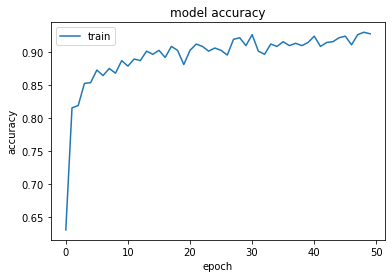

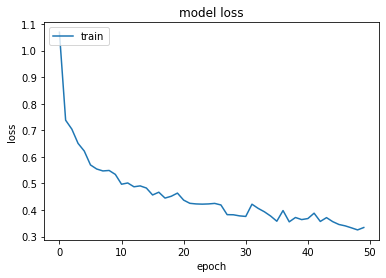

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


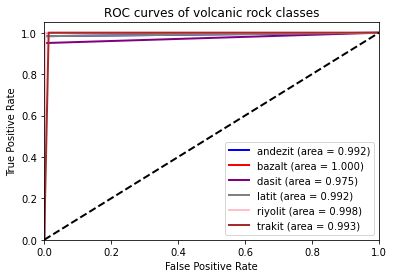

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 57  0  0  3]
 [ 0  0  0 59  0  1]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 3
Epoch 1/50
53/53 [==============================] - 20s 189ms/step - loss: 1.4728 - accuracy: 0.4507
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 0.8397 - accuracy: 0.7596
Epoch 3/50
53/53 [==============================] - 10s 195ms/step - loss: 0.7354 - accuracy: 0.8022
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.6914 - accuracy: 0.8377
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.7222 - accuracy: 0.7947
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.6560 - accuracy: 0.8210
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.6374 - accuracy: 0.8458
Epoch 8/50
53/53 [==============================] - 10s 188ms/step - loss: 0.6289 - accuracy: 0.8407
Epoch 9/50
53/53 [==============================] - 10s 1

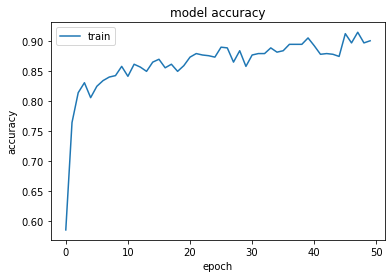

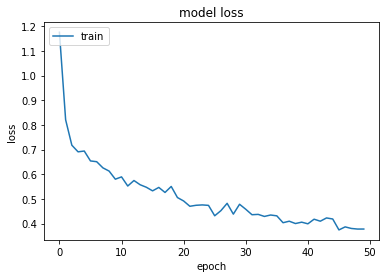

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


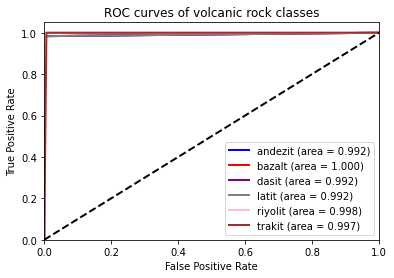

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 59  0  0  1]
 [ 0  0  0 59  0  1]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 4
Epoch 1/50
53/53 [==============================] - 19s 188ms/step - loss: 1.4896 - accuracy: 0.4245
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 0.9414 - accuracy: 0.7169
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 0.8625 - accuracy: 0.7545
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.7713 - accuracy: 0.8055
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.8118 - accuracy: 0.7854
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.7839 - accuracy: 0.8087
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.6926 - accuracy: 0.8501
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 0.6586 - accuracy: 0.8671
Epoch 9/50
53/53 [==============================] - 10s 1

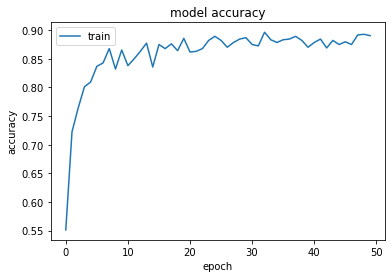

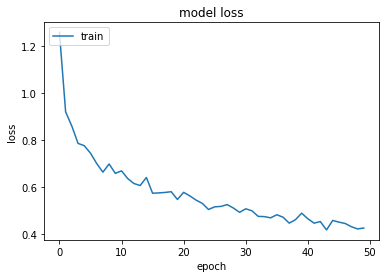

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


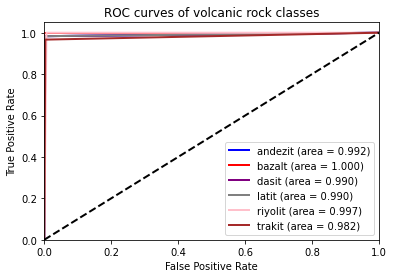

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 59  0  0  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  1  1  0 58]]
fold: 5
Epoch 1/50
53/53 [==============================] - 21s 189ms/step - loss: 1.3962 - accuracy: 0.4427
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 0.7960 - accuracy: 0.7862
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 0.6645 - accuracy: 0.8325
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.6448 - accuracy: 0.8496
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 0.6228 - accuracy: 0.8557
Epoch 6/50
53/53 [==============================] - 10s 191ms/step - loss: 0.6077 - accuracy: 0.8486
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.6229 - accuracy: 0.8421
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 0.6118 - accuracy: 0.8405
Epoch 9/50
53/53 [==============================] - 10s 1

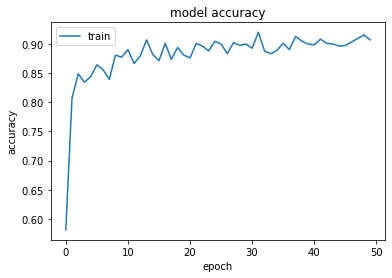

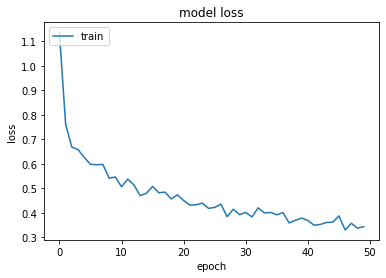

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


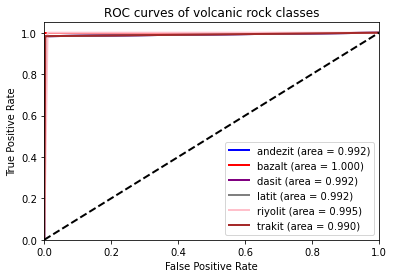

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 59  0  0  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  1 59]]

number of folds: 6
average test accuracies: 0.986


In [25]:
#Training Process

EPOCHS=50
BATCH_SIZE=16
x_fold=6
#optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-07, decay=0.0)
optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
#optimizer=SGD(lr=0.001, momentum=0.0, nesterov=False)
#optimizer=RMSprop(lr=0.0001, rho=0.9)

metric="accuracy" 
loss="categorical_crossentropy" 
model_checkpoint_callback=keras.callbacks.ModelCheckpoint("bestmodel.h5",save_best_only=True,save_weights_only=True,)
callbacks=[model_checkpoint_callback]

test_accuracies = []

for i in range(x_fold):
  print("fold:", i)
  input_shape=(height, width, 3)
  Transfer_Model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
  #Transfer_Model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
  
  add_model = Sequential()

  add_model.add(Flatten())
  add_model.add(BatchNormalization())
  add_model.add(Dense(8, activation='relu'))
  add_model.add(Dropout(0.25))
  add_model.add(BatchNormalization())
        
  add_model.add(Dense(class_number, activation='softmax'))

  model = Model(inputs=Transfer_Model.input, outputs=add_model(Transfer_Model.output))

  model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
  history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
  #predictions
  y_pred= model.predict(X_test)
  y_pred=np.argmax(y_pred,axis=1).astype(np.float32)
  y_pred = keras.utils.to_categorical(y_pred, class_number)

  train_score = model.evaluate(X_train, y_train)
  test_score = model.evaluate(X_test, y_test)
  print(train_score)
  print(test_score)
  test_accuracies.append(test_score[1])

  #Plot accuracy 
  plt.close("all")
  plt.plot(history.history['accuracy'])
  #plt.plot(history.history['val_accuracy'])  
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"acc_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot loss
  plt.close("all")
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_accuracy'])
      
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"loss_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot ROC
  plot_roc(i)
  make_report(i)

print("")
print("number of folds:", i+1)
print("average test accuracies:", round(sum(test_accuracies)/len(test_accuracies), 3))


DenseNet121 with RMSprop optimizer, reduced dense layer in add_model

In [26]:
save_path="../ychen/COMP551/mini4_data/classification_results/DenseNet121_RMSprop_reducedDense/"
print(os.path.isdir(save_path))
if os.path.isdir(save_path)==True:
  print("directory exists")
else:
  os.mkdir(save_path)
  print("new directory was created")

False
new directory was created


In [27]:
print(save_path)

../ychen/COMP551/mini4_data/classification_results/DenseNet121_RMSprop_reducedDense/


fold: 0
Epoch 1/50
53/53 [==============================] - 28s 201ms/step - loss: 1.4458 - accuracy: 0.4244
Epoch 2/50
53/53 [==============================] - 11s 204ms/step - loss: 0.9597 - accuracy: 0.7219
Epoch 3/50
53/53 [==============================] - 11s 203ms/step - loss: 0.9028 - accuracy: 0.7403
Epoch 4/50
53/53 [==============================] - 11s 201ms/step - loss: 0.8109 - accuracy: 0.8039
Epoch 5/50
53/53 [==============================] - 10s 198ms/step - loss: 0.7678 - accuracy: 0.8443
Epoch 6/50
53/53 [==============================] - 11s 198ms/step - loss: 0.7624 - accuracy: 0.8288
Epoch 7/50
53/53 [==============================] - 10s 197ms/step - loss: 0.7230 - accuracy: 0.8665
Epoch 8/50
53/53 [==============================] - 11s 198ms/step - loss: 0.7118 - accuracy: 0.8540
Epoch 9/50
53/53 [==============================] - 11s 201ms/step - loss: 0.7114 - accuracy: 0.8327
Epoch 10/50
53/53 [==============================] - 11s 200ms/step - loss: 0.7029 

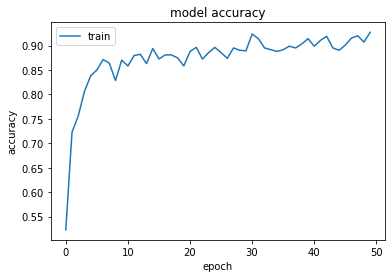

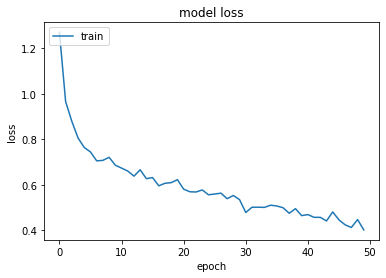

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


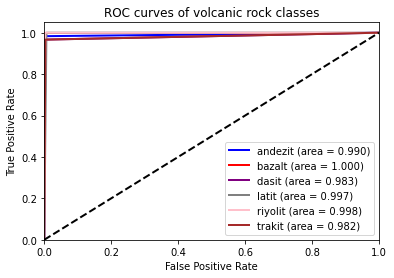

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 1  0 58  0  0  1]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  2  0 58]]
fold: 1
Epoch 1/50
53/53 [==============================] - 28s 199ms/step - loss: 1.5472 - accuracy: 0.3911
Epoch 2/50
53/53 [==============================] - 11s 201ms/step - loss: 0.9290 - accuracy: 0.7315
Epoch 3/50
53/53 [==============================] - 11s 204ms/step - loss: 0.7496 - accuracy: 0.8309
Epoch 4/50
53/53 [==============================] - 11s 202ms/step - loss: 0.7499 - accuracy: 0.8082
Epoch 5/50
53/53 [==============================] - 11s 201ms/step - loss: 0.7203 - accuracy: 0.8138
Epoch 6/50
53/53 [==============================] - 11s 199ms/step - loss: 0.6547 - accuracy: 0.8342
Epoch 7/50
53/53 [==============================] - 10s 197ms/step - loss: 0.6772 - accuracy: 0.8299
Epoch 8/50
53/53 [==============================] - 11s 198ms/step - loss: 0.6024 - accuracy: 0.8775
Epoch 9/50
53/53 [==============================] - 10s 1

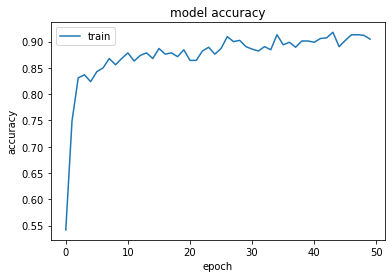

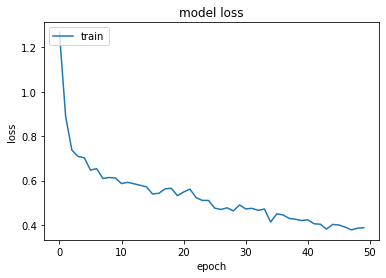

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


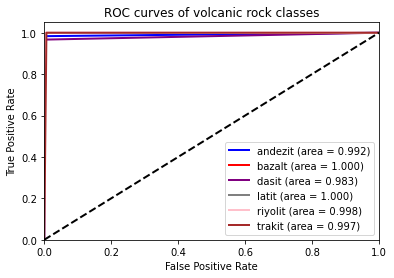

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 58  0  0  2]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 2
Epoch 1/50
53/53 [==============================] - 28s 196ms/step - loss: 1.5876 - accuracy: 0.3958
Epoch 2/50
53/53 [==============================] - 11s 200ms/step - loss: 1.0364 - accuracy: 0.7172
Epoch 3/50
53/53 [==============================] - 11s 202ms/step - loss: 0.9341 - accuracy: 0.8071
Epoch 4/50
53/53 [==============================] - 11s 202ms/step - loss: 0.8617 - accuracy: 0.8641
Epoch 5/50
53/53 [==============================] - 11s 199ms/step - loss: 0.7992 - accuracy: 0.8601
Epoch 6/50
53/53 [==============================] - 10s 198ms/step - loss: 0.7863 - accuracy: 0.8697
Epoch 7/50
53/53 [==============================] - 10s 197ms/step - loss: 0.7796 - accuracy: 0.8728
Epoch 8/50
53/53 [==============================] - 10s 196ms/step - loss: 0.7403 - accuracy: 0.8903
Epoch 9/50
53/53 [==============================] - 10s 1

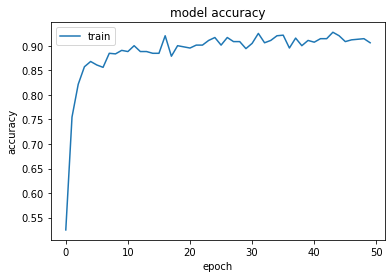

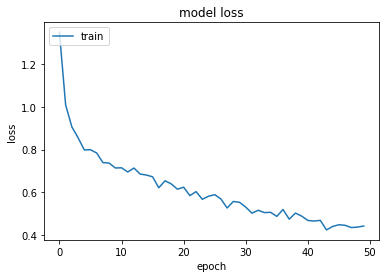

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


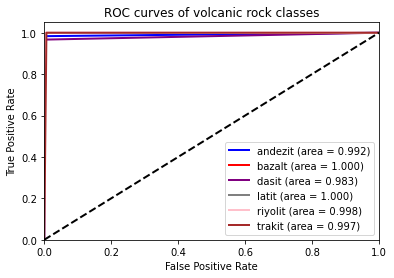

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 58  0  0  2]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 3
Epoch 1/50
53/53 [==============================] - 28s 196ms/step - loss: 1.4881 - accuracy: 0.4467
Epoch 2/50
53/53 [==============================] - 11s 200ms/step - loss: 0.9925 - accuracy: 0.7510
Epoch 3/50
53/53 [==============================] - 11s 201ms/step - loss: 0.8988 - accuracy: 0.7754
Epoch 4/50
53/53 [==============================] - 11s 201ms/step - loss: 0.8144 - accuracy: 0.8606
Epoch 5/50
53/53 [==============================] - 11s 199ms/step - loss: 0.8164 - accuracy: 0.8582
Epoch 6/50
53/53 [==============================] - 10s 197ms/step - loss: 0.7577 - accuracy: 0.8466
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 0.7333 - accuracy: 0.8731
Epoch 8/50
53/53 [==============================] - 10s 196ms/step - loss: 0.7365 - accuracy: 0.8640
Epoch 9/50
53/53 [==============================] - 10s 1

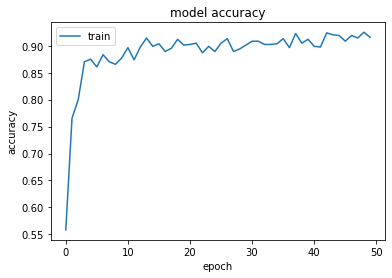

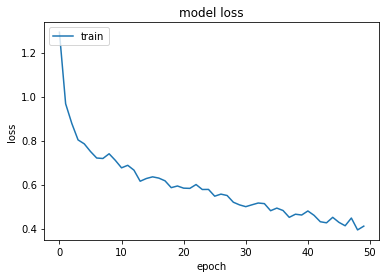

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


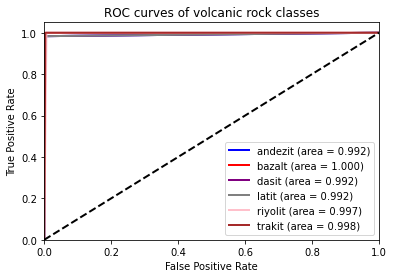

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 59  0  0  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 4
Epoch 1/50
53/53 [==============================] - 28s 197ms/step - loss: 1.5130 - accuracy: 0.4419
Epoch 2/50
53/53 [==============================] - 11s 200ms/step - loss: 0.9579 - accuracy: 0.7143
Epoch 3/50
53/53 [==============================] - 11s 201ms/step - loss: 0.8564 - accuracy: 0.7793
Epoch 4/50
53/53 [==============================] - 11s 201ms/step - loss: 0.7990 - accuracy: 0.8506
Epoch 5/50
53/53 [==============================] - 11s 199ms/step - loss: 0.8209 - accuracy: 0.7976
Epoch 6/50
53/53 [==============================] - 10s 197ms/step - loss: 0.7395 - accuracy: 0.8345
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 0.7316 - accuracy: 0.8468
Epoch 8/50
53/53 [==============================] - 10s 196ms/step - loss: 0.7752 - accuracy: 0.8086
Epoch 9/50
53/53 [==============================] - 10s 1

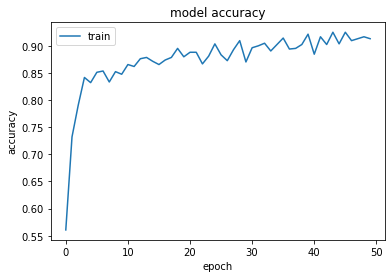

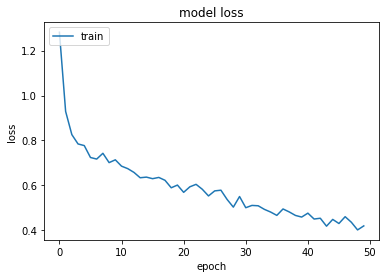

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


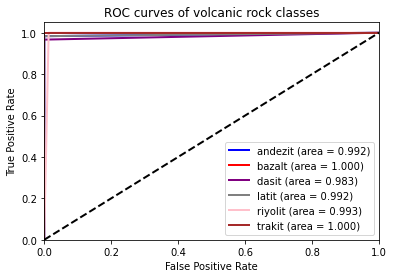

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 58  0  2  0]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 5
Epoch 1/50
53/53 [==============================] - 28s 197ms/step - loss: 1.5437 - accuracy: 0.4185
Epoch 2/50
53/53 [==============================] - 11s 201ms/step - loss: 0.8961 - accuracy: 0.7437
Epoch 3/50
53/53 [==============================] - 11s 202ms/step - loss: 0.7994 - accuracy: 0.8099
Epoch 4/50
53/53 [==============================] - 11s 201ms/step - loss: 0.7645 - accuracy: 0.8326
Epoch 5/50
53/53 [==============================] - 11s 199ms/step - loss: 0.6979 - accuracy: 0.8343
Epoch 6/50
53/53 [==============================] - 10s 198ms/step - loss: 0.6804 - accuracy: 0.8654
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 0.6797 - accuracy: 0.8616
Epoch 8/50
53/53 [==============================] - 10s 196ms/step - loss: 0.6440 - accuracy: 0.8465
Epoch 9/50
53/53 [==============================] - 10s 1

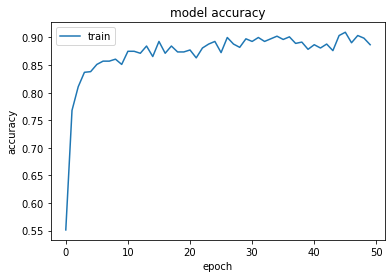

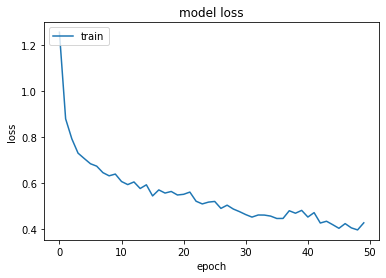

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


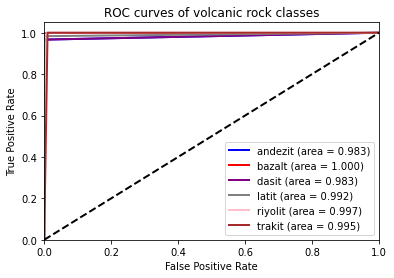

[[58  0  0  0  1  1]
 [ 0 60  0  0  0  0]
 [ 0  0 58  0  0  2]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]

number of folds: 6
average test accuracies: 0.989


In [28]:
#Training Process

EPOCHS=50
BATCH_SIZE=16
x_fold=6
#optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-07, decay=0.0)
#optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
#optimizer=SGD(lr=0.001, momentum=0.0, nesterov=False)
optimizer=RMSprop(lr=0.0001, rho=0.9)

metric="accuracy" 
loss="categorical_crossentropy" 
model_checkpoint_callback=keras.callbacks.ModelCheckpoint("bestmodel.h5",save_best_only=True,save_weights_only=True,)
callbacks=[model_checkpoint_callback]

test_accuracies = []

for i in range(x_fold):
  print("fold:", i)
  input_shape=(height, width, 3)
  Transfer_Model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
  #Transfer_Model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
  
  add_model = Sequential()

  add_model.add(Flatten())
  add_model.add(BatchNormalization())
  add_model.add(Dense(8, activation='relu'))
  add_model.add(Dropout(0.25))
  add_model.add(BatchNormalization())
        
  add_model.add(Dense(class_number, activation='softmax'))

  model = Model(inputs=Transfer_Model.input, outputs=add_model(Transfer_Model.output))

  model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
  history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
  #predictions
  y_pred= model.predict(X_test)
  y_pred=np.argmax(y_pred,axis=1).astype(np.float32)
  y_pred = keras.utils.to_categorical(y_pred, class_number)

  train_score = model.evaluate(X_train, y_train)
  test_score = model.evaluate(X_test, y_test)
  print(train_score)
  print(test_score)
  test_accuracies.append(test_score[1])

  #Plot accuracy 
  plt.close("all")
  plt.plot(history.history['accuracy'])
  #plt.plot(history.history['val_accuracy'])  
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"acc_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot loss
  plt.close("all")
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_accuracy'])
      
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"loss_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot ROC
  plot_roc(i)
  make_report(i)

print("")
print("number of folds:", i+1)
print("average test accuracies:", round(sum(test_accuracies)/len(test_accuracies), 3))

# 55m37s

DenseNet121 with ADAM optimizer, removed both batch normalization layers

In [30]:
save_path="../ychen/COMP551/mini4_data/classification_results/DenseNet121_ADAM_removeBN/"
print(os.path.isdir(save_path))
if os.path.isdir(save_path)==True:
  print("directory exists")
else:
  os.mkdir(save_path)
  print("new directory was created")

False
new directory was created


In [31]:
print(save_path)

../ychen/COMP551/mini4_data/classification_results/DenseNet121_ADAM_removeBN/


fold: 0
Epoch 1/50
53/53 [==============================] - 19s 192ms/step - loss: 2.1442 - accuracy: 0.2057
Epoch 2/50
53/53 [==============================] - 10s 195ms/step - loss: 1.5626 - accuracy: 0.3047
Epoch 3/50
53/53 [==============================] - 10s 192ms/step - loss: 1.3592 - accuracy: 0.4892
Epoch 4/50
53/53 [==============================] - 10s 190ms/step - loss: 1.1653 - accuracy: 0.5343
Epoch 5/50
53/53 [==============================] - 10s 189ms/step - loss: 1.0800 - accuracy: 0.5744
Epoch 6/50
53/53 [==============================] - 10s 189ms/step - loss: 1.0875 - accuracy: 0.5501
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.9970 - accuracy: 0.5933
Epoch 8/50
53/53 [==============================] - 10s 190ms/step - loss: 0.9610 - accuracy: 0.6137
Epoch 9/50
53/53 [==============================] - 10s 190ms/step - loss: 1.0380 - accuracy: 0.5380
Epoch 10/50
53/53 [==============================] - 10s 191ms/step - loss: 0.9041 

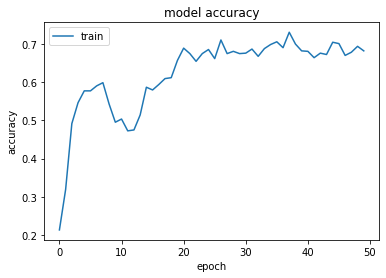

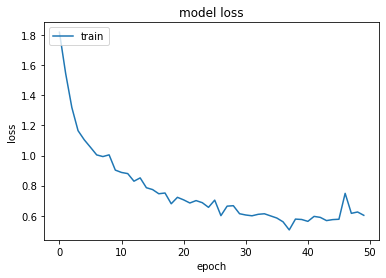

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


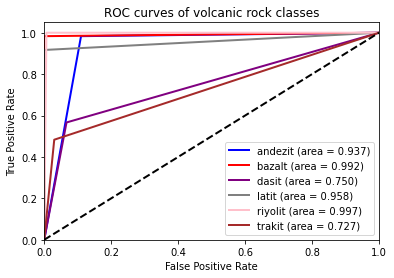

[[59  0  0  0  1  0]
 [ 1 59  0  0  0  0]
 [17  0 34  0  0  9]
 [ 4  0  0 55  1  0]
 [ 0  0  0  0 60  0]
 [11  0 20  0  0 29]]
fold: 1
Epoch 1/50
53/53 [==============================] - 19s 187ms/step - loss: 1.9887 - accuracy: 0.2190
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 1.6743 - accuracy: 0.2538
Epoch 3/50
53/53 [==============================] - 10s 193ms/step - loss: 1.6172 - accuracy: 0.2734
Epoch 4/50
53/53 [==============================] - 10s 193ms/step - loss: 1.5901 - accuracy: 0.3130
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 1.5465 - accuracy: 0.3089
Epoch 6/50
53/53 [==============================] - 10s 189ms/step - loss: 1.5085 - accuracy: 0.3204
Epoch 7/50
53/53 [==============================] - 10s 188ms/step - loss: 1.5522 - accuracy: 0.2902
Epoch 8/50
53/53 [==============================] - 10s 188ms/step - loss: 1.5232 - accuracy: 0.2786
Epoch 9/50
53/53 [==============================] - 10s 1

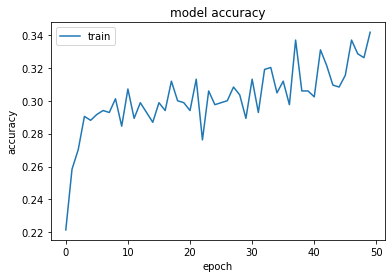

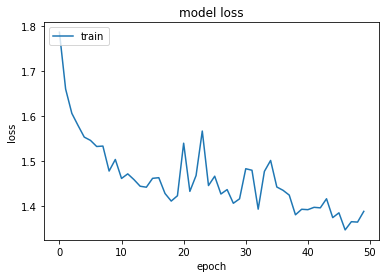

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


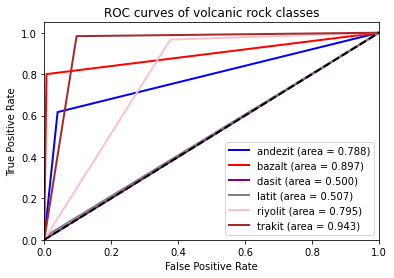

[[37  2  0  0  2 19]
 [12 48  0  0  0  0]
 [ 0  0  0  1 56  3]
 [ 0  0  0  1 54  5]
 [ 0  0  0  0 58  2]
 [ 0  0  0  0  1 59]]
fold: 2


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
53/53 [==============================] - 19s 187ms/step - loss: 1.9086 - accuracy: 0.2422
Epoch 2/50
53/53 [==============================] - 10s 190ms/step - loss: 1.6591 - accuracy: 0.2572
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 1.5981 - accuracy: 0.2888
Epoch 4/50
53/53 [==============================] - 10s 193ms/step - loss: 1.5344 - accuracy: 0.2990
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 1.5658 - accuracy: 0.2883
Epoch 6/50
53/53 [==============================] - 10s 189ms/step - loss: 1.6041 - accuracy: 0.3031
Epoch 7/50
53/53 [==============================] - 10s 187ms/step - loss: 1.6114 - accuracy: 0.2871
Epoch 8/50
53/53 [==============================] - 10s 188ms/step - loss: 1.5867 - accuracy: 0.2826
Epoch 9/50
53/53 [==============================] - 10s 188ms/step - loss: 1.5478 - accuracy: 0.3138
Epoch 10/50
53/53 [==============================] - 10s 189ms/step - loss: 1.5439 - accura

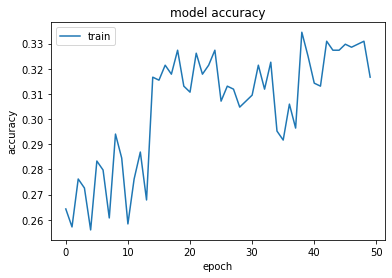

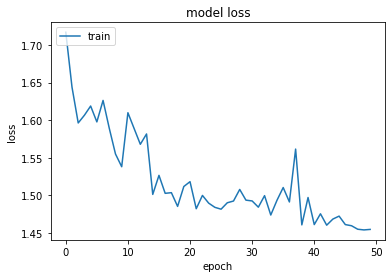

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


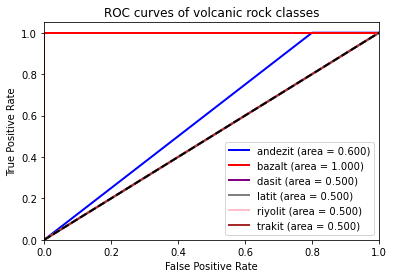

[[60  0  0  0  0  0]
 [ 0 60  0  0  0  0]
 [60  0  0  0  0  0]
 [60  0  0  0  0  0]
 [60  0  0  0  0  0]
 [60  0  0  0  0  0]]
fold: 3


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
53/53 [==============================] - 19s 188ms/step - loss: 1.8667 - accuracy: 0.2784
Epoch 2/50
53/53 [==============================] - 10s 190ms/step - loss: 1.7164 - accuracy: 0.2632
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 1.4558 - accuracy: 0.3778
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 1.4526 - accuracy: 0.4004
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 1.3886 - accuracy: 0.4096
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 1.4130 - accuracy: 0.3931
Epoch 7/50
53/53 [==============================] - 10s 188ms/step - loss: 1.3693 - accuracy: 0.4006
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 1.3068 - accuracy: 0.4204
Epoch 9/50
53/53 [==============================] - 10s 188ms/step - loss: 1.3486 - accuracy: 0.3997
Epoch 10/50
53/53 [==============================] - 10s 190ms/step - loss: 1.3078 - accura

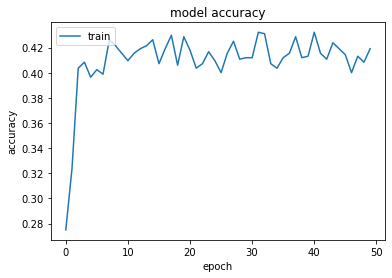

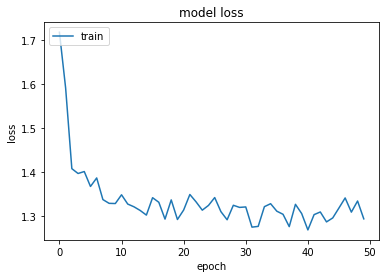

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


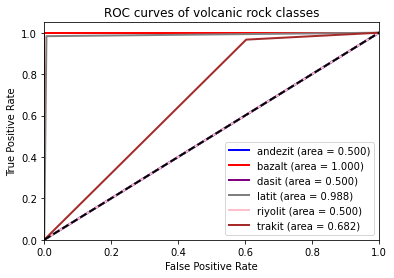

[[ 0  0  0  0  0 60]
 [ 0 60  0  0  0  0]
 [ 0  0  0  0  0 60]
 [ 0  0  0 59  0  1]
 [ 0  0  0  0  0 60]
 [ 0  0  0  2  0 58]]
fold: 4


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
53/53 [==============================] - 19s 185ms/step - loss: 1.9729 - accuracy: 0.1956
Epoch 2/50
53/53 [==============================] - 10s 190ms/step - loss: 1.5948 - accuracy: 0.2774
Epoch 3/50
53/53 [==============================] - 10s 192ms/step - loss: 1.5409 - accuracy: 0.3303
Epoch 4/50
53/53 [==============================] - 10s 193ms/step - loss: 1.5679 - accuracy: 0.2849
Epoch 5/50
53/53 [==============================] - 10s 190ms/step - loss: 1.5592 - accuracy: 0.2856
Epoch 6/50
53/53 [==============================] - 10s 189ms/step - loss: 1.5629 - accuracy: 0.2974
Epoch 7/50
53/53 [==============================] - 10s 187ms/step - loss: 1.5663 - accuracy: 0.3079
Epoch 8/50
53/53 [==============================] - 10s 188ms/step - loss: 1.5821 - accuracy: 0.2903
Epoch 9/50
53/53 [==============================] - 10s 187ms/step - loss: 1.5648 - accuracy: 0.2983
Epoch 10/50
53/53 [==============================] - 10s 188ms/step - loss: 1.5443 - accura

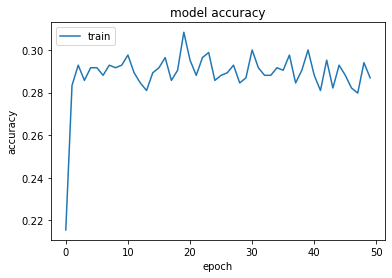

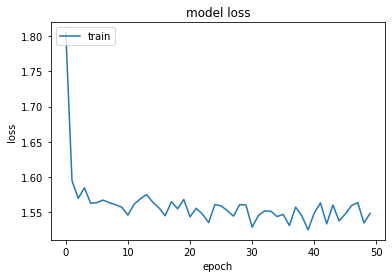

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


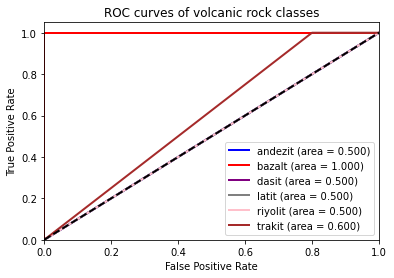

[[ 0  0  0  0  0 60]
 [ 0 60  0  0  0  0]
 [ 0  0  0  0  0 60]
 [ 0  0  0  0  0 60]
 [ 0  0  0  0  0 60]
 [ 0  0  0  0  0 60]]
fold: 5


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
53/53 [==============================] - 19s 187ms/step - loss: 1.7772 - accuracy: 0.3224
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 1.2645 - accuracy: 0.4908
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 1.3839 - accuracy: 0.4099
Epoch 4/50
53/53 [==============================] - 10s 193ms/step - loss: 1.1562 - accuracy: 0.4980
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 1.1048 - accuracy: 0.5452
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 1.1336 - accuracy: 0.5055
Epoch 7/50
53/53 [==============================] - 10s 188ms/step - loss: 1.0616 - accuracy: 0.5497
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 1.0827 - accuracy: 0.5731
Epoch 9/50
53/53 [==============================] - 10s 188ms/step - loss: 1.1439 - accuracy: 0.5573
Epoch 10/50
53/53 [==============================] - 10s 189ms/step - loss: 1.0468 - accura

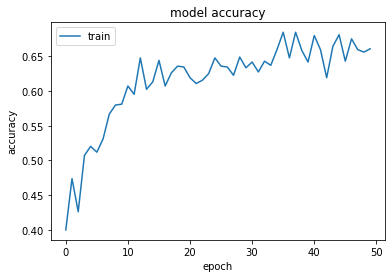

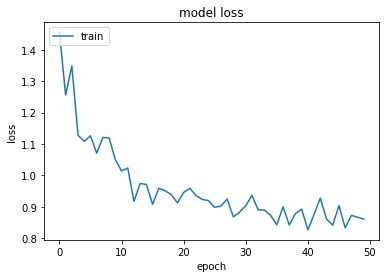

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


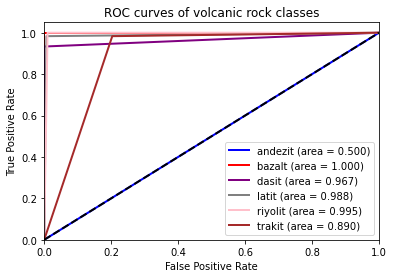

[[ 0  0  0  0  1 59]
 [ 0 60  0  0  0  0]
 [ 0  0 56  1  1  2]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  1  0 59]]

number of folds: 6
average test accuracies: 0.56


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
#Training Process

EPOCHS=50
BATCH_SIZE=16
x_fold=6
#optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-07, decay=0.0)
optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
#optimizer=SGD(lr=0.001, momentum=0.0, nesterov=False)
#optimizer=RMSprop(lr=0.0001, rho=0.9)

metric="accuracy" 
loss="categorical_crossentropy" 
model_checkpoint_callback=keras.callbacks.ModelCheckpoint("bestmodel.h5",save_best_only=True,save_weights_only=True,)
callbacks=[model_checkpoint_callback]

test_accuracies = []

for i in range(x_fold):
  print("fold:", i)
  input_shape=(height, width, 3)
  Transfer_Model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
  #Transfer_Model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
  
  add_model = Sequential()

  add_model.add(Flatten())
  # add_model.add(BatchNormalization())
  add_model.add(Dense(16, activation='relu'))
  add_model.add(Dropout(0.25))
  # add_model.add(BatchNormalization())
        
  add_model.add(Dense(class_number, activation='softmax'))
  #add_model.add(Tranfer_Model.output)

  model = Model(inputs=Transfer_Model.input, outputs=add_model(Transfer_Model.output))

  model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
  history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
  #predictions
  y_pred= model.predict(X_test)
  y_pred=np.argmax(y_pred,axis=1).astype(np.float32)
  y_pred = keras.utils.to_categorical(y_pred, class_number)

  train_score = model.evaluate(X_train, y_train)
  test_score = model.evaluate(X_test, y_test)
  print(train_score)
  print(test_score)
  test_accuracies.append(test_score[1])

  #Plot accuracy 
  plt.close("all")
  plt.plot(history.history['accuracy'])
  #plt.plot(history.history['val_accuracy'])  
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"acc_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot loss
  plt.close("all")
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_accuracy'])
      
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"loss_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot ROC
  plot_roc(i)
  make_report(i)

print("")
print("number of folds:", i+1)
print("average test accuracies:", round(sum(test_accuracies)/len(test_accuracies), 3))

# 52m17s

DenseNet121 with RMSprop optimizer, removed both batch normalization layers

In [33]:
save_path="../ychen/COMP551/mini4_data/classification_results/DenseNet121_RMSprop_removeBN/"
print(os.path.isdir(save_path))
if os.path.isdir(save_path)==True:
  print("directory exists")
else:
  os.mkdir(save_path)
  print("new directory was created")

False
new directory was created


In [34]:
print(save_path)

../ychen/COMP551/mini4_data/classification_results/DenseNet121_RMSprop_removeBN/


fold: 0
Epoch 1/50
53/53 [==============================] - 29s 201ms/step - loss: 1.7817 - accuracy: 0.3779
Epoch 2/50
53/53 [==============================] - 11s 203ms/step - loss: 0.8060 - accuracy: 0.7076
Epoch 3/50
53/53 [==============================] - 11s 202ms/step - loss: 0.4915 - accuracy: 0.7841
Epoch 4/50
53/53 [==============================] - 11s 200ms/step - loss: 0.3574 - accuracy: 0.8475
Epoch 5/50
53/53 [==============================] - 11s 198ms/step - loss: 0.3215 - accuracy: 0.8651
Epoch 6/50
53/53 [==============================] - 10s 197ms/step - loss: 0.2827 - accuracy: 0.9092
Epoch 7/50
53/53 [==============================] - 10s 197ms/step - loss: 0.2774 - accuracy: 0.9026
Epoch 8/50
53/53 [==============================] - 10s 198ms/step - loss: 0.2975 - accuracy: 0.9086
Epoch 9/50
53/53 [==============================] - 11s 199ms/step - loss: 0.2504 - accuracy: 0.9132
Epoch 10/50
53/53 [==============================] - 11s 200ms/step - loss: 0.2802 

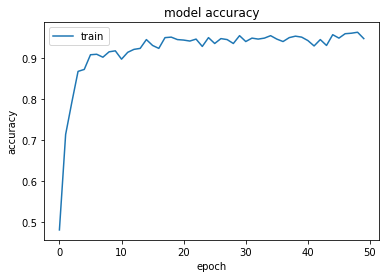

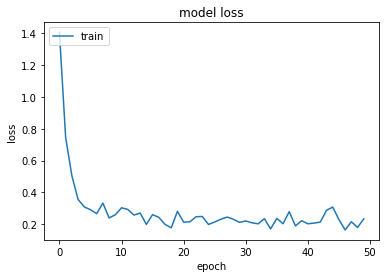

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


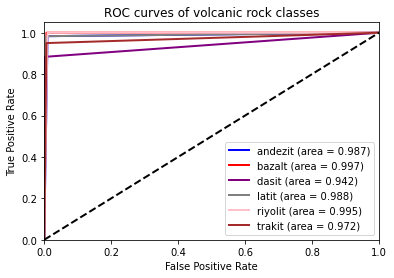

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 2  2 53  1  0  2]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 1  0  0  1  1 57]]
fold: 1
Epoch 1/50
53/53 [==============================] - 27s 196ms/step - loss: 1.8784 - accuracy: 0.2236
Epoch 2/50
53/53 [==============================] - 11s 199ms/step - loss: 1.0800 - accuracy: 0.5893
Epoch 3/50
53/53 [==============================] - 11s 201ms/step - loss: 0.6221 - accuracy: 0.6909
Epoch 4/50
53/53 [==============================] - 11s 202ms/step - loss: 0.4867 - accuracy: 0.7796
Epoch 5/50
53/53 [==============================] - 11s 199ms/step - loss: 0.4120 - accuracy: 0.7864
Epoch 6/50
53/53 [==============================] - 10s 198ms/step - loss: 0.3718 - accuracy: 0.7969
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 0.3535 - accuracy: 0.8509
Epoch 8/50
53/53 [==============================] - 10s 196ms/step - loss: 0.4250 - accuracy: 0.8417
Epoch 9/50
53/53 [==============================] - 10s 1

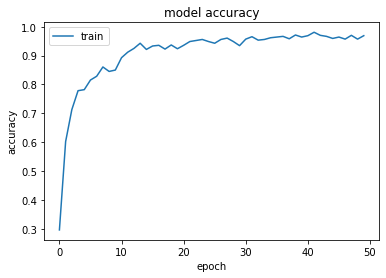

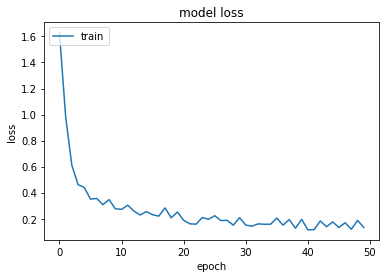

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


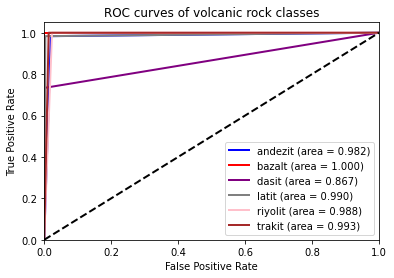

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 6  0 44  1  5  4]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 2
Epoch 1/50
53/53 [==============================] - 26s 197ms/step - loss: 1.9041 - accuracy: 0.2894
Epoch 2/50
53/53 [==============================] - 11s 202ms/step - loss: 0.9235 - accuracy: 0.6171
Epoch 3/50
53/53 [==============================] - 11s 204ms/step - loss: 0.5792 - accuracy: 0.7684
Epoch 4/50
53/53 [==============================] - 11s 203ms/step - loss: 0.4715 - accuracy: 0.7844
Epoch 5/50
53/53 [==============================] - 11s 200ms/step - loss: 0.3828 - accuracy: 0.8586
Epoch 6/50
53/53 [==============================] - 10s 198ms/step - loss: 0.2471 - accuracy: 0.8992
Epoch 7/50
53/53 [==============================] - 10s 198ms/step - loss: 0.2880 - accuracy: 0.8629
Epoch 8/50
53/53 [==============================] - 11s 199ms/step - loss: 0.2539 - accuracy: 0.8768
Epoch 9/50
53/53 [==============================] - 11s 1

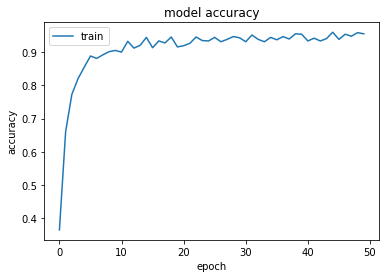

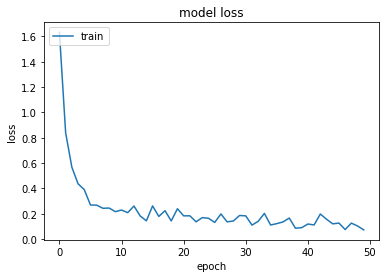

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


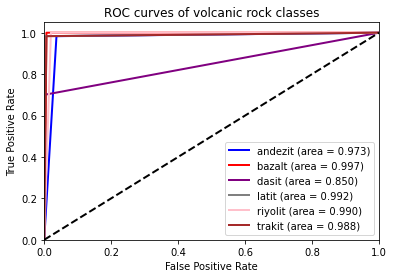

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [11  2 42  0  3  2]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  1 59]]
fold: 3
Epoch 1/50
53/53 [==============================] - 27s 199ms/step - loss: 2.6010 - accuracy: 0.2246
Epoch 2/50
53/53 [==============================] - 11s 201ms/step - loss: 1.2143 - accuracy: 0.5140
Epoch 3/50
53/53 [==============================] - 11s 203ms/step - loss: 0.6099 - accuracy: 0.7651
Epoch 4/50
53/53 [==============================] - 11s 203ms/step - loss: 0.4464 - accuracy: 0.8190
Epoch 5/50
53/53 [==============================] - 11s 200ms/step - loss: 0.2438 - accuracy: 0.8770
Epoch 6/50
53/53 [==============================] - 11s 199ms/step - loss: 0.3433 - accuracy: 0.8714
Epoch 7/50
53/53 [==============================] - 10s 198ms/step - loss: 0.2209 - accuracy: 0.9081
Epoch 8/50
53/53 [==============================] - 11s 198ms/step - loss: 0.2314 - accuracy: 0.8841
Epoch 9/50
53/53 [==============================] - 10s 1

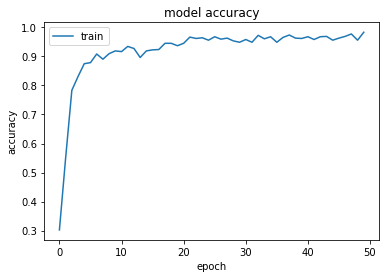

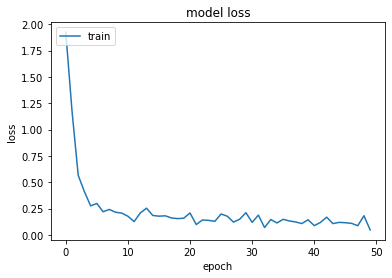

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


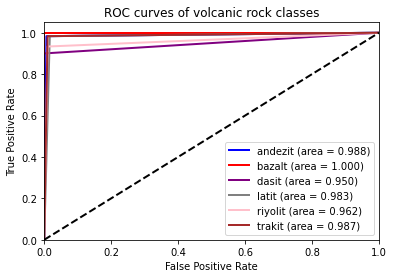

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 2  0 54  0  1  3]
 [ 0  0  0 59  1  0]
 [ 0  0  0  4 56  0]
 [ 0  0  0  1  0 59]]
fold: 4
Epoch 1/50
53/53 [==============================] - 27s 197ms/step - loss: 1.9881 - accuracy: 0.2596
Epoch 2/50
53/53 [==============================] - 11s 201ms/step - loss: 1.1910 - accuracy: 0.4723
Epoch 3/50
53/53 [==============================] - 11s 203ms/step - loss: 0.6119 - accuracy: 0.7439
Epoch 4/50
53/53 [==============================] - 11s 202ms/step - loss: 0.4299 - accuracy: 0.8235
Epoch 5/50
53/53 [==============================] - 11s 200ms/step - loss: 0.3755 - accuracy: 0.8489
Epoch 6/50
53/53 [==============================] - 11s 198ms/step - loss: 0.2558 - accuracy: 0.9130
Epoch 7/50
53/53 [==============================] - 10s 198ms/step - loss: 0.1939 - accuracy: 0.9196
Epoch 8/50
53/53 [==============================] - 10s 197ms/step - loss: 0.2810 - accuracy: 0.8938
Epoch 9/50
53/53 [==============================] - 10s 1

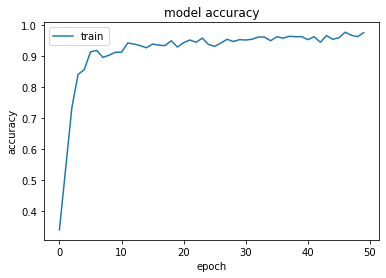

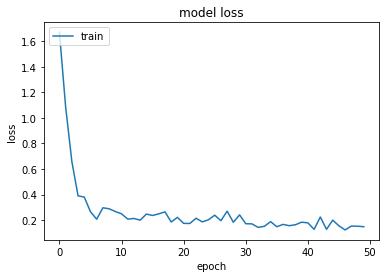

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


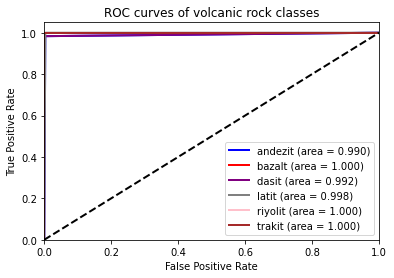

[[59  0  0  1  0  0]
 [ 0 60  0  0  0  0]
 [ 1  0 59  0  0  0]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 5
Epoch 1/50
53/53 [==============================] - 27s 195ms/step - loss: 1.8338 - accuracy: 0.2398
Epoch 2/50
53/53 [==============================] - 10s 198ms/step - loss: 1.1256 - accuracy: 0.5366
Epoch 3/50
53/53 [==============================] - 11s 201ms/step - loss: 0.6332 - accuracy: 0.7693
Epoch 4/50
53/53 [==============================] - 11s 201ms/step - loss: 0.4510 - accuracy: 0.8054
Epoch 5/50
53/53 [==============================] - 11s 200ms/step - loss: 0.4392 - accuracy: 0.8268
Epoch 6/50
53/53 [==============================] - 11s 198ms/step - loss: 0.3720 - accuracy: 0.8423
Epoch 7/50
53/53 [==============================] - 10s 197ms/step - loss: 0.3331 - accuracy: 0.8509
Epoch 8/50
53/53 [==============================] - 10s 197ms/step - loss: 0.3129 - accuracy: 0.8695
Epoch 9/50
53/53 [==============================] - 10s 1

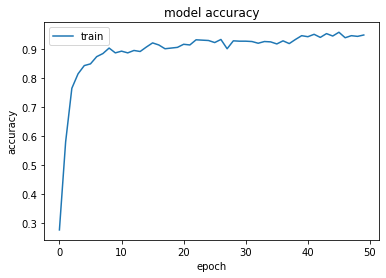

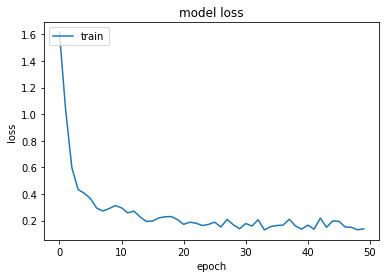

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


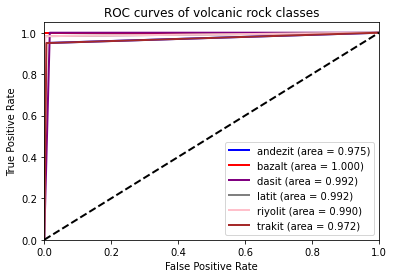

[[57  0  2  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 60  0  0  0]
 [ 0  0  0 59  0  1]
 [ 0  0  0  0 59  1]
 [ 0  0  3  0  0 57]]

number of folds: 6
average test accuracies: 0.966


In [35]:
#Training Process

EPOCHS=50
BATCH_SIZE=16
x_fold=6
#optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-07, decay=0.0)
#optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
#optimizer=SGD(lr=0.001, momentum=0.0, nesterov=False)
optimizer=RMSprop(lr=0.0001, rho=0.9)

metric="accuracy" 
loss="categorical_crossentropy" 
model_checkpoint_callback=keras.callbacks.ModelCheckpoint("bestmodel.h5",save_best_only=True,save_weights_only=True,)
callbacks=[model_checkpoint_callback]

test_accuracies = []

for i in range(x_fold):
  print("fold:", i)
  input_shape=(height, width, 3)
  Transfer_Model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
  #Transfer_Model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
  
  add_model = Sequential()

  add_model.add(Flatten())
  # add_model.add(BatchNormalization())
  add_model.add(Dense(16, activation='relu'))
  add_model.add(Dropout(0.25))
  # add_model.add(BatchNormalization())
        
  add_model.add(Dense(class_number, activation='softmax'))
  #add_model.add(Tranfer_Model.output)

  model = Model(inputs=Transfer_Model.input, outputs=add_model(Transfer_Model.output))

  model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
  history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
  #predictions
  y_pred= model.predict(X_test)
  y_pred=np.argmax(y_pred,axis=1).astype(np.float32)
  y_pred = keras.utils.to_categorical(y_pred, class_number)

  train_score = model.evaluate(X_train, y_train)
  test_score = model.evaluate(X_test, y_test)
  print(train_score)
  print(test_score)
  test_accuracies.append(test_score[1])

  #Plot accuracy 
  plt.close("all")
  plt.plot(history.history['accuracy'])
  #plt.plot(history.history['val_accuracy'])  
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"acc_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot loss
  plt.close("all")
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_accuracy'])
      
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"loss_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot ROC
  plot_roc(i)
  make_report(i)

print("")
print("number of folds:", i+1)
print("average test accuracies:", round(sum(test_accuracies)/len(test_accuracies), 3))

# 55m33s

DenseNet121 with ADAM optimizer, drop rate = 0

In [36]:
save_path="../ychen/COMP551/mini4_data/classification_results/DenseNet121_ADAM_dropRate0/"
print(os.path.isdir(save_path))
if os.path.isdir(save_path)==True:
  print("directory exists")
else:
  os.mkdir(save_path)
  print("new directory was created")

False
new directory was created


In [37]:
print(save_path)

../ychen/COMP551/mini4_data/classification_results/DenseNet121_ADAM_dropRate0/


fold: 0
Epoch 1/50
53/53 [==============================] - 21s 181ms/step - loss: 1.3197 - accuracy: 0.5066
Epoch 2/50
53/53 [==============================] - 10s 181ms/step - loss: 0.4486 - accuracy: 0.9356
Epoch 3/50
53/53 [==============================] - 10s 182ms/step - loss: 0.2788 - accuracy: 0.9858
Epoch 4/50
53/53 [==============================] - 10s 182ms/step - loss: 0.1983 - accuracy: 0.9991
Epoch 5/50
53/53 [==============================] - 10s 182ms/step - loss: 0.1941 - accuracy: 0.9915
Epoch 6/50
53/53 [==============================] - 10s 183ms/step - loss: 0.1679 - accuracy: 0.9989
Epoch 7/50
53/53 [==============================] - 10s 183ms/step - loss: 0.1421 - accuracy: 1.0000
Epoch 8/50
53/53 [==============================] - 10s 185ms/step - loss: 0.1242 - accuracy: 1.0000
Epoch 9/50
53/53 [==============================] - 10s 185ms/step - loss: 0.1127 - accuracy: 1.0000
Epoch 10/50
53/53 [==============================] - 10s 186ms/step - loss: 0.0968 

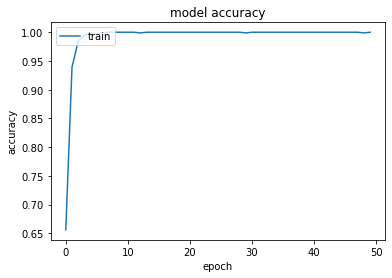

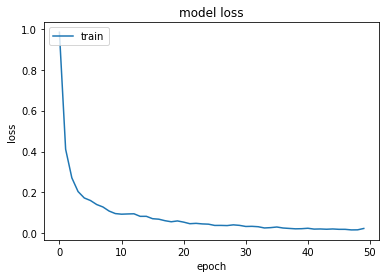

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


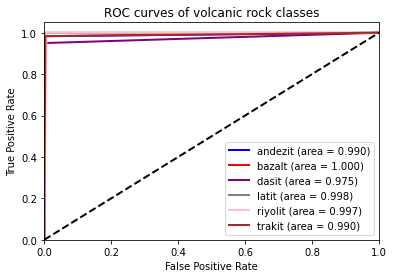

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 1  0 57  0  1  1]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  1  0 59]]
fold: 1
Epoch 1/50
53/53 [==============================] - 20s 189ms/step - loss: 1.0397 - accuracy: 0.6545
Epoch 2/50
53/53 [==============================] - 10s 192ms/step - loss: 0.2241 - accuracy: 0.9713
Epoch 3/50
53/53 [==============================] - 10s 195ms/step - loss: 0.1555 - accuracy: 0.9918
Epoch 4/50
53/53 [==============================] - 10s 195ms/step - loss: 0.1144 - accuracy: 0.9981
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 0.0969 - accuracy: 0.9928
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.1138 - accuracy: 0.9851
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0742 - accuracy: 0.9950
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0674 - accuracy: 0.9981
Epoch 9/50
53/53 [==============================] - 10s 1

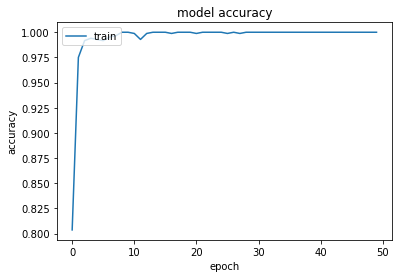

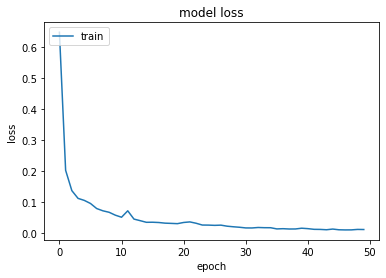

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


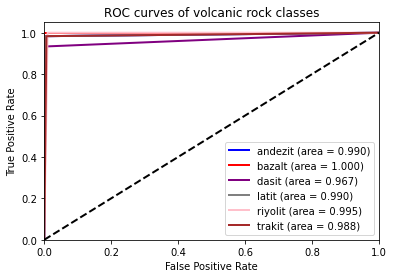

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 1  0 56  0  1  2]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  1  0 59]]
fold: 2
Epoch 1/50
53/53 [==============================] - 21s 189ms/step - loss: 0.9892 - accuracy: 0.6840
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 0.3093 - accuracy: 0.9629
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 0.1851 - accuracy: 0.9853
Epoch 4/50
53/53 [==============================] - 10s 195ms/step - loss: 0.1601 - accuracy: 0.9877
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.1421 - accuracy: 0.9916
Epoch 6/50
53/53 [==============================] - 10s 191ms/step - loss: 0.1066 - accuracy: 0.9995
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0893 - accuracy: 1.0000
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0813 - accuracy: 0.9999
Epoch 9/50
53/53 [==============================] - 10s 1

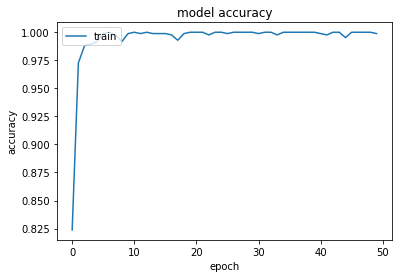

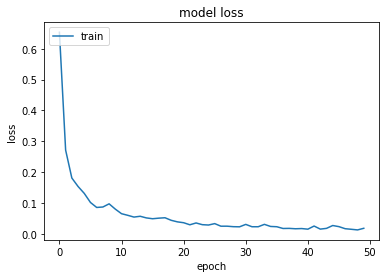

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


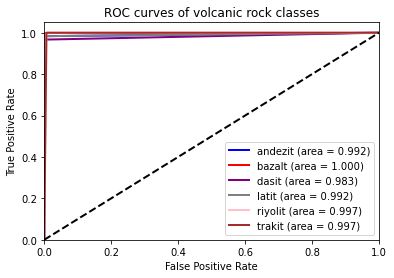

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 58  0  0  2]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 3
Epoch 1/50
53/53 [==============================] - 19s 189ms/step - loss: 1.0203 - accuracy: 0.6591
Epoch 2/50
53/53 [==============================] - 10s 192ms/step - loss: 0.2978 - accuracy: 0.9463
Epoch 3/50
53/53 [==============================] - 10s 195ms/step - loss: 0.1303 - accuracy: 0.9970
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.1275 - accuracy: 0.9932
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.1043 - accuracy: 0.9950
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.0900 - accuracy: 0.9996
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0740 - accuracy: 0.9989
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0822 - accuracy: 0.9978
Epoch 9/50
53/53 [==============================] - 10s 1

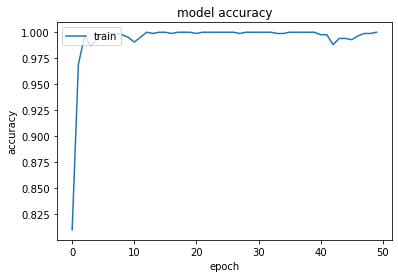

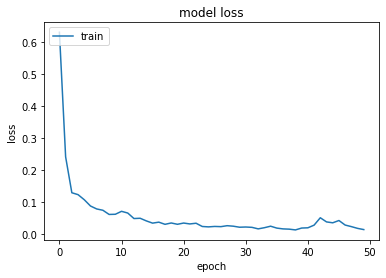

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


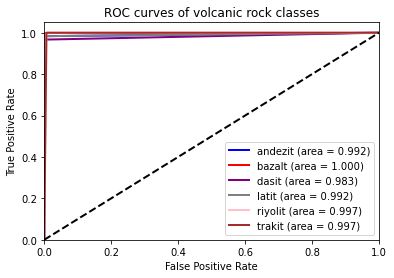

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 58  0  0  2]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 4
Epoch 1/50
53/53 [==============================] - 19s 188ms/step - loss: 0.9474 - accuracy: 0.7041
Epoch 2/50
53/53 [==============================] - 10s 192ms/step - loss: 0.2706 - accuracy: 0.9577
Epoch 3/50
53/53 [==============================] - 10s 195ms/step - loss: 0.2435 - accuracy: 0.9615
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.1610 - accuracy: 0.9877
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.1261 - accuracy: 0.9928
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.0839 - accuracy: 1.0000
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0861 - accuracy: 0.9960
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0881 - accuracy: 0.9962
Epoch 9/50
53/53 [==============================] - 10s 1

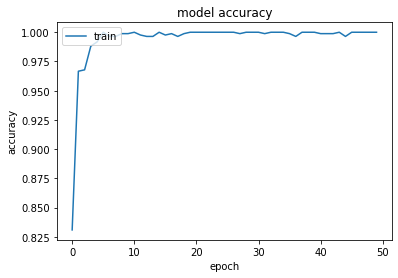

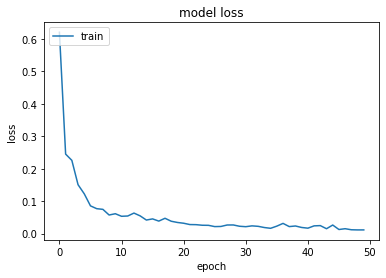

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


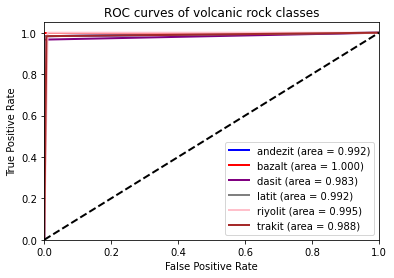

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 58  0  1  1]
 [ 0  0  0 59  0  1]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  1 59]]
fold: 5
Epoch 1/50
53/53 [==============================] - 20s 189ms/step - loss: 0.9440 - accuracy: 0.7000
Epoch 2/50
53/53 [==============================] - 10s 192ms/step - loss: 0.2143 - accuracy: 0.9837
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 0.1522 - accuracy: 0.9923
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.1365 - accuracy: 0.9937
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.1086 - accuracy: 0.9956
Epoch 6/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0906 - accuracy: 0.9981
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0813 - accuracy: 0.9982
Epoch 8/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0728 - accuracy: 0.9965
Epoch 9/50
53/53 [==============================] - 10s 1

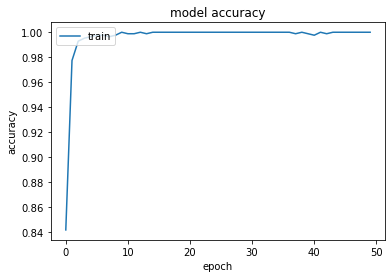

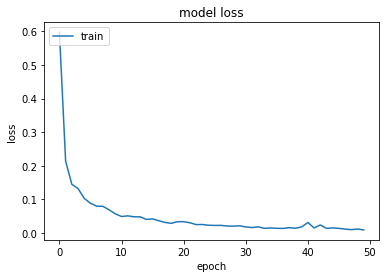

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


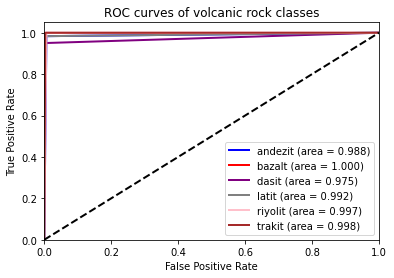

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 2  0 57  0  0  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]

number of folds: 6
average test accuracies: 0.986


In [38]:
#Training Process

EPOCHS=50
BATCH_SIZE=16
x_fold=6
#optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-07, decay=0.0)
optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
#optimizer=SGD(lr=0.001, momentum=0.0, nesterov=False)
#optimizer=RMSprop(lr=0.0001, rho=0.9)

metric="accuracy" 
loss="categorical_crossentropy" 
model_checkpoint_callback=keras.callbacks.ModelCheckpoint("bestmodel.h5",save_best_only=True,save_weights_only=True,)
callbacks=[model_checkpoint_callback]

test_accuracies = []

for i in range(x_fold):
  print("fold:", i)
  input_shape=(height, width, 3)
  Transfer_Model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
  #Transfer_Model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
  
  add_model = Sequential()

  add_model.add(Flatten())
  add_model.add(BatchNormalization())
  add_model.add(Dense(16, activation='relu'))
  add_model.add(Dropout(0))
  add_model.add(BatchNormalization())
        
  add_model.add(Dense(class_number, activation='softmax'))
  #add_model.add(Tranfer_Model.output)

  model = Model(inputs=Transfer_Model.input, outputs=add_model(Transfer_Model.output))

  model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
  history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
  #predictions
  y_pred= model.predict(X_test)
  y_pred=np.argmax(y_pred,axis=1).astype(np.float32)
  y_pred = keras.utils.to_categorical(y_pred, class_number)

  train_score = model.evaluate(X_train, y_train)
  test_score = model.evaluate(X_test, y_test)
  print(train_score)
  print(test_score)
  test_accuracies.append(test_score[1])

  #Plot accuracy 
  plt.close("all")
  plt.plot(history.history['accuracy'])
  #plt.plot(history.history['val_accuracy'])  
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"acc_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot loss
  plt.close("all")
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_accuracy'])
      
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"loss_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot ROC
  plot_roc(i)
  make_report(i)

print("")
print("number of folds:", i+1)
print("average test accuracies:", round(sum(test_accuracies)/len(test_accuracies), 3))

# 52m34s

DenseNet121 with RMSprop optimizer, drop rate = 0

In [39]:
save_path="../ychen/COMP551/mini4_data/classification_results/DenseNet121_RMSprop_dropRate0/"
print(os.path.isdir(save_path))
if os.path.isdir(save_path)==True:
  print("directory exists")
else:
  os.mkdir(save_path)
  print("new directory was created")

False
new directory was created


In [40]:
print(save_path)

../ychen/COMP551/mini4_data/classification_results/DenseNet121_RMSprop_dropRate0/


fold: 0
Epoch 1/50
53/53 [==============================] - 27s 198ms/step - loss: 1.1502 - accuracy: 0.5740
Epoch 2/50
53/53 [==============================] - 11s 201ms/step - loss: 0.3237 - accuracy: 0.9675
Epoch 3/50
53/53 [==============================] - 11s 202ms/step - loss: 0.2335 - accuracy: 0.9886
Epoch 4/50
53/53 [==============================] - 11s 200ms/step - loss: 0.1890 - accuracy: 0.9852
Epoch 5/50
53/53 [==============================] - 10s 198ms/step - loss: 0.1770 - accuracy: 0.9897
Epoch 6/50
53/53 [==============================] - 10s 196ms/step - loss: 0.1272 - accuracy: 0.9953
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 0.1147 - accuracy: 0.9961
Epoch 8/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0946 - accuracy: 0.9992
Epoch 9/50
53/53 [==============================] - 11s 199ms/step - loss: 0.0955 - accuracy: 0.9954
Epoch 10/50
53/53 [==============================] - 11s 199ms/step - loss: 0.0862 

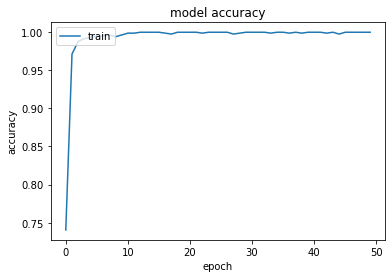

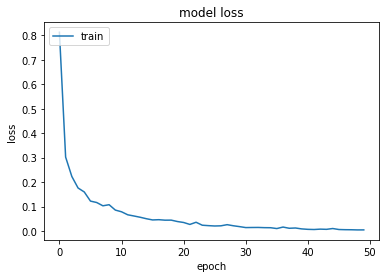

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


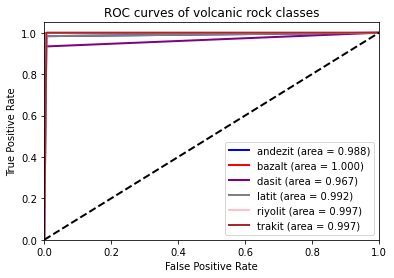

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 2  0 56  0  0  2]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 1
Epoch 1/50
53/53 [==============================] - 27s 196ms/step - loss: 1.1486 - accuracy: 0.5728
Epoch 2/50
53/53 [==============================] - 11s 200ms/step - loss: 0.3055 - accuracy: 0.9630
Epoch 3/50
53/53 [==============================] - 11s 204ms/step - loss: 0.2213 - accuracy: 0.9748
Epoch 4/50
53/53 [==============================] - 11s 202ms/step - loss: 0.1732 - accuracy: 0.9892
Epoch 5/50
53/53 [==============================] - 11s 200ms/step - loss: 0.1589 - accuracy: 0.9895
Epoch 6/50
53/53 [==============================] - 10s 197ms/step - loss: 0.1127 - accuracy: 0.9993
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0888 - accuracy: 1.0000
Epoch 8/50
53/53 [==============================] - 10s 196ms/step - loss: 0.1012 - accuracy: 0.9945
Epoch 9/50
53/53 [==============================] - 10s 1

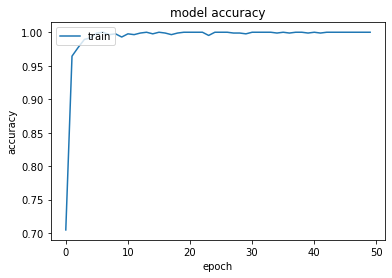

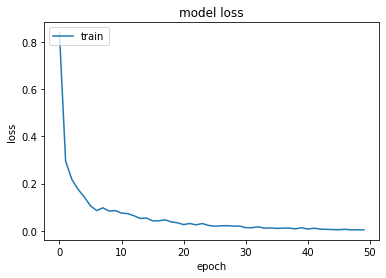

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


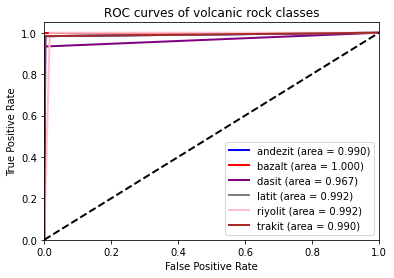

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 1  0 56  0  2  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  1 59]]
fold: 2
Epoch 1/50
53/53 [==============================] - 28s 197ms/step - loss: 1.2287 - accuracy: 0.5638
Epoch 2/50
53/53 [==============================] - 11s 201ms/step - loss: 0.3612 - accuracy: 0.9525
Epoch 3/50
53/53 [==============================] - 11s 203ms/step - loss: 0.2287 - accuracy: 0.9845
Epoch 4/50
53/53 [==============================] - 11s 202ms/step - loss: 0.1647 - accuracy: 0.9941
Epoch 5/50
53/53 [==============================] - 11s 199ms/step - loss: 0.1268 - accuracy: 0.9981
Epoch 6/50
53/53 [==============================] - 10s 197ms/step - loss: 0.1254 - accuracy: 0.9955
Epoch 7/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0955 - accuracy: 0.9988
Epoch 8/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0981 - accuracy: 0.9959
Epoch 9/50
53/53 [==============================] - 11s 1

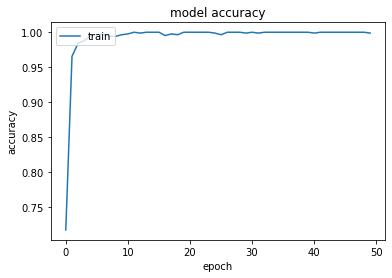

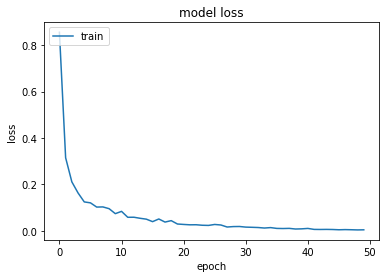

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


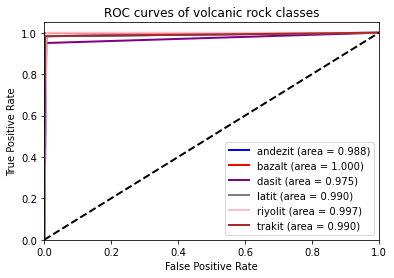

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 2  0 57  0  0  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  1  0 59]]
fold: 3
Epoch 1/50
53/53 [==============================] - 30s 200ms/step - loss: 1.2211 - accuracy: 0.5811
Epoch 2/50
53/53 [==============================] - 11s 202ms/step - loss: 0.2912 - accuracy: 0.9746
Epoch 3/50
53/53 [==============================] - 11s 204ms/step - loss: 0.2007 - accuracy: 0.9916
Epoch 4/50
53/53 [==============================] - 11s 203ms/step - loss: 0.1546 - accuracy: 0.9901
Epoch 5/50
53/53 [==============================] - 11s 202ms/step - loss: 0.1366 - accuracy: 0.9907
Epoch 6/50
53/53 [==============================] - 11s 200ms/step - loss: 0.1122 - accuracy: 0.9967
Epoch 7/50
53/53 [==============================] - 11s 200ms/step - loss: 0.0954 - accuracy: 0.9987
Epoch 8/50
53/53 [==============================] - 11s 200ms/step - loss: 0.0782 - accuracy: 0.9993
Epoch 9/50
53/53 [==============================] - 11s 2

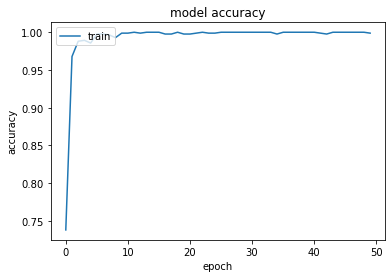

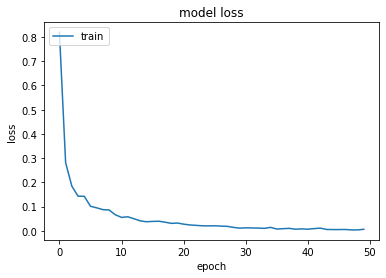

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


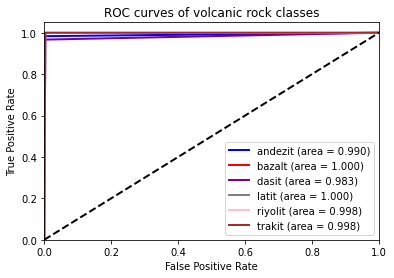

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 1  0 58  0  0  1]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 4
Epoch 1/50
53/53 [==============================] - 30s 199ms/step - loss: 1.1657 - accuracy: 0.5729
Epoch 2/50
53/53 [==============================] - 11s 201ms/step - loss: 0.3405 - accuracy: 0.9700
Epoch 3/50
53/53 [==============================] - 11s 204ms/step - loss: 0.2232 - accuracy: 0.9971
Epoch 4/50
53/53 [==============================] - 11s 202ms/step - loss: 0.2227 - accuracy: 0.9795
Epoch 5/50
53/53 [==============================] - 11s 200ms/step - loss: 0.1454 - accuracy: 1.0000
Epoch 6/50
53/53 [==============================] - 11s 198ms/step - loss: 0.1310 - accuracy: 0.9984
Epoch 7/50
53/53 [==============================] - 10s 198ms/step - loss: 0.1225 - accuracy: 0.9967
Epoch 8/50
53/53 [==============================] - 10s 197ms/step - loss: 0.1122 - accuracy: 0.9986
Epoch 9/50
53/53 [==============================] - 11s 1

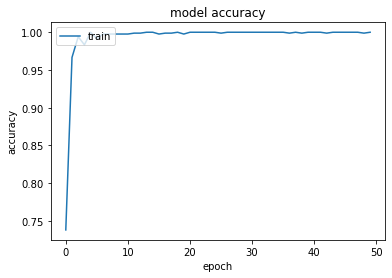

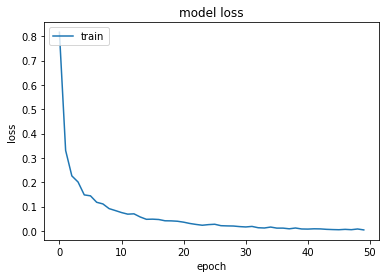

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


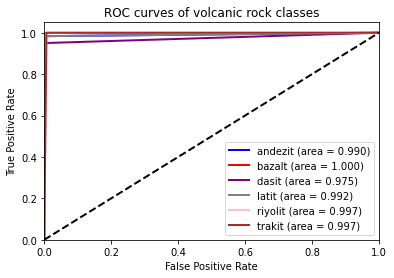

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 1  0 57  0  0  2]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 5
Epoch 1/50
53/53 [==============================] - 26s 196ms/step - loss: 1.1756 - accuracy: 0.5842
Epoch 2/50
53/53 [==============================] - 11s 199ms/step - loss: 0.3486 - accuracy: 0.9476
Epoch 3/50
53/53 [==============================] - 11s 202ms/step - loss: 0.2147 - accuracy: 0.9872
Epoch 4/50
53/53 [==============================] - 11s 201ms/step - loss: 0.1653 - accuracy: 0.9861
Epoch 5/50
53/53 [==============================] - 11s 199ms/step - loss: 0.1529 - accuracy: 0.9911
Epoch 6/50
53/53 [==============================] - 10s 197ms/step - loss: 0.1357 - accuracy: 0.9870
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0997 - accuracy: 0.9959
Epoch 8/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0862 - accuracy: 0.9994
Epoch 9/50
53/53 [==============================] - 10s 1

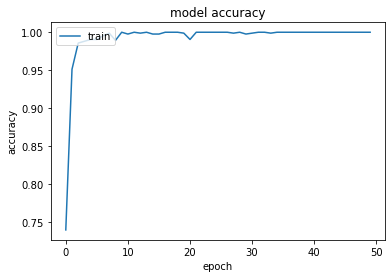

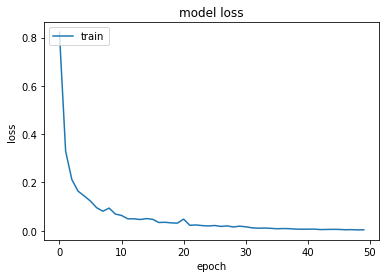

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


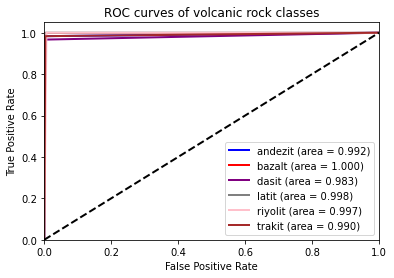

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 58  0  1  1]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  1  0 59]]

number of folds: 6
average test accuracies: 0.986


In [41]:
#Training Process

EPOCHS=50
BATCH_SIZE=16
x_fold=6
#optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-07, decay=0.0)
#optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
#optimizer=SGD(lr=0.001, momentum=0.0, nesterov=False)
optimizer=RMSprop(lr=0.0001, rho=0.9)

metric="accuracy" 
loss="categorical_crossentropy" 
model_checkpoint_callback=keras.callbacks.ModelCheckpoint("bestmodel.h5",save_best_only=True,save_weights_only=True,)
callbacks=[model_checkpoint_callback]

test_accuracies = []

for i in range(x_fold):
  print("fold:", i)
  input_shape=(height, width, 3)
  Transfer_Model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
  #Transfer_Model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
  
  add_model = Sequential()

  add_model.add(Flatten())
  add_model.add(BatchNormalization())
  add_model.add(Dense(16, activation='relu'))
  add_model.add(Dropout(0))
  add_model.add(BatchNormalization())
        
  add_model.add(Dense(class_number, activation='softmax'))
  #add_model.add(Tranfer_Model.output)

  model = Model(inputs=Transfer_Model.input, outputs=add_model(Transfer_Model.output))

  model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
  history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
  #predictions
  y_pred= model.predict(X_test)
  y_pred=np.argmax(y_pred,axis=1).astype(np.float32)
  y_pred = keras.utils.to_categorical(y_pred, class_number)

  train_score = model.evaluate(X_train, y_train)
  test_score = model.evaluate(X_test, y_test)
  print(train_score)
  print(test_score)
  test_accuracies.append(test_score[1])

  #Plot accuracy 
  plt.close("all")
  plt.plot(history.history['accuracy'])
  #plt.plot(history.history['val_accuracy'])  
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"acc_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot loss
  plt.close("all")
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_accuracy'])
      
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"loss_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot ROC
  plot_roc(i)
  make_report(i)

print("")
print("number of folds:", i+1)
print("average test accuracies:", round(sum(test_accuracies)/len(test_accuracies), 3))

# 55m33s

DenseNet121 with ADAM optimizer, drop rate = 0.5

In [42]:
save_path="../ychen/COMP551/mini4_data/classification_results/DenseNet121_ADAM_dropRate50/"
print(os.path.isdir(save_path))
if os.path.isdir(save_path)==True:
  print("directory exists")
else:
  os.mkdir(save_path)
  print("new directory was created")

False
new directory was created


In [43]:
print(save_path)

../ychen/COMP551/mini4_data/classification_results/DenseNet121_ADAM_dropRate50/


fold: 0
Epoch 1/50
53/53 [==============================] - 21s 195ms/step - loss: 1.8136 - accuracy: 0.3190
Epoch 2/50
53/53 [==============================] - 10s 197ms/step - loss: 1.0324 - accuracy: 0.6424
Epoch 3/50
53/53 [==============================] - 10s 194ms/step - loss: 0.8618 - accuracy: 0.7481
Epoch 4/50
53/53 [==============================] - 10s 192ms/step - loss: 0.7815 - accuracy: 0.8240
Epoch 5/50
53/53 [==============================] - 10s 190ms/step - loss: 0.7519 - accuracy: 0.8001
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.7299 - accuracy: 0.8143
Epoch 7/50
53/53 [==============================] - 10s 190ms/step - loss: 0.7050 - accuracy: 0.8131
Epoch 8/50
53/53 [==============================] - 10s 191ms/step - loss: 0.6833 - accuracy: 0.8436
Epoch 9/50
53/53 [==============================] - 10s 192ms/step - loss: 0.6512 - accuracy: 0.8391
Epoch 10/50
53/53 [==============================] - 10s 193ms/step - loss: 0.6722 

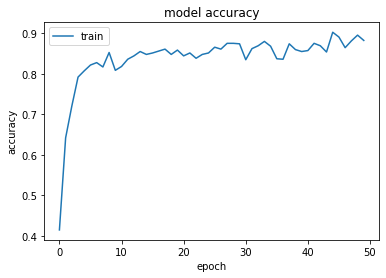

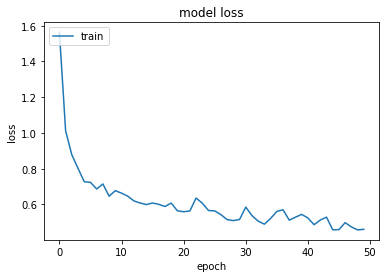

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


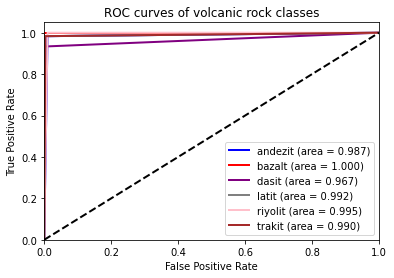

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 3  0 56  0  0  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  1 59]]
fold: 1
Epoch 1/50
53/53 [==============================] - 20s 189ms/step - loss: 1.5436 - accuracy: 0.4361
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 0.8774 - accuracy: 0.7270
Epoch 3/50
53/53 [==============================] - 10s 195ms/step - loss: 0.7161 - accuracy: 0.8333
Epoch 4/50
53/53 [==============================] - 10s 195ms/step - loss: 0.6811 - accuracy: 0.8287
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.6767 - accuracy: 0.8215
Epoch 6/50
53/53 [==============================] - 10s 191ms/step - loss: 0.6598 - accuracy: 0.8243
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.5645 - accuracy: 0.8682
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 0.5846 - accuracy: 0.8381
Epoch 9/50
53/53 [==============================] - 10s 1

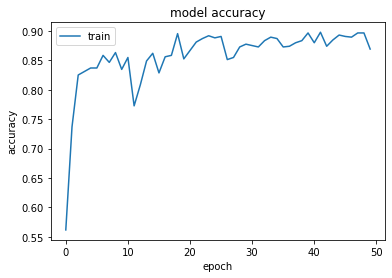

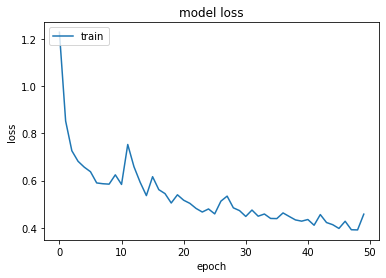

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


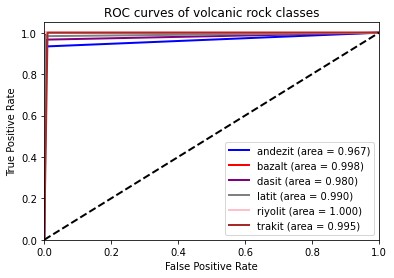

[[56  1  2  1  0  0]
 [ 0 60  0  0  0  0]
 [ 0  0 58  0  0  2]
 [ 0  0  0 59  0  1]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 2
Epoch 1/50
53/53 [==============================] - 20s 190ms/step - loss: 1.5209 - accuracy: 0.3965
Epoch 2/50
53/53 [==============================] - 10s 192ms/step - loss: 0.8348 - accuracy: 0.7242
Epoch 3/50
53/53 [==============================] - 10s 195ms/step - loss: 0.7554 - accuracy: 0.7947
Epoch 4/50
53/53 [==============================] - 10s 195ms/step - loss: 0.6885 - accuracy: 0.8138
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.6439 - accuracy: 0.8227
Epoch 6/50
53/53 [==============================] - 10s 191ms/step - loss: 0.5874 - accuracy: 0.8326
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.6591 - accuracy: 0.8250
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 0.5948 - accuracy: 0.8399
Epoch 9/50
53/53 [==============================] - 10s 1

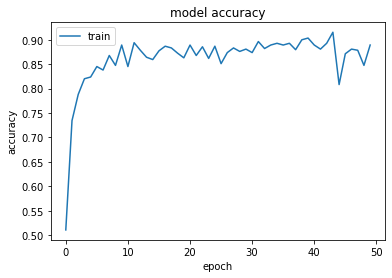

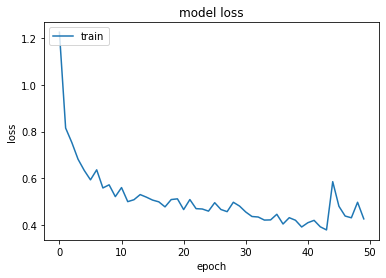

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


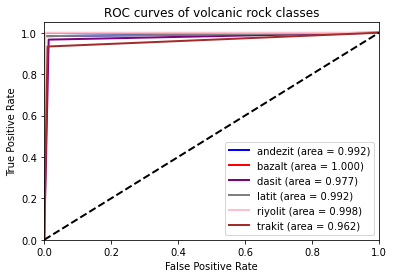

[[59  0  0  0  0  1]
 [ 0 60  0  0  0  0]
 [ 0  0 58  0  1  1]
 [ 0  0  0 59  0  1]
 [ 0  0  0  0 60  0]
 [ 0  0  4  0  0 56]]
fold: 3
Epoch 1/50
53/53 [==============================] - 20s 189ms/step - loss: 1.5225 - accuracy: 0.4262
Epoch 2/50
53/53 [==============================] - 10s 192ms/step - loss: 0.8859 - accuracy: 0.6967
Epoch 3/50
53/53 [==============================] - 10s 195ms/step - loss: 0.6554 - accuracy: 0.8389
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.6524 - accuracy: 0.8423
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.6093 - accuracy: 0.8442
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.5951 - accuracy: 0.8263
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.5620 - accuracy: 0.8710
Epoch 8/50
53/53 [==============================] - 10s 188ms/step - loss: 0.5519 - accuracy: 0.8894
Epoch 9/50
53/53 [==============================] - 10s 1

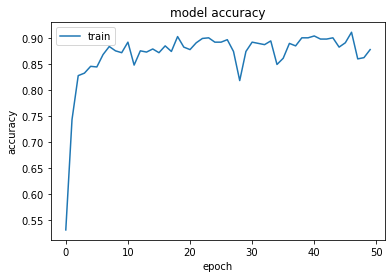

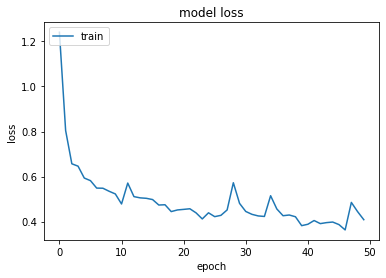

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


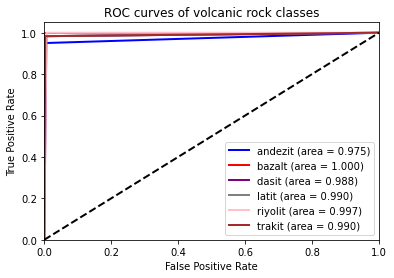

[[57  0  2  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 59  0  0  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  1  0 59]]
fold: 4
Epoch 1/50
53/53 [==============================] - 20s 189ms/step - loss: 1.4318 - accuracy: 0.4668
Epoch 2/50
53/53 [==============================] - 10s 192ms/step - loss: 0.7445 - accuracy: 0.7576
Epoch 3/50
53/53 [==============================] - 10s 195ms/step - loss: 0.6313 - accuracy: 0.8005
Epoch 4/50
53/53 [==============================] - 10s 195ms/step - loss: 0.5674 - accuracy: 0.8567
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.5793 - accuracy: 0.8572
Epoch 6/50
53/53 [==============================] - 10s 191ms/step - loss: 0.5614 - accuracy: 0.8496
Epoch 7/50
53/53 [==============================] - 10s 190ms/step - loss: 0.4909 - accuracy: 0.8771
Epoch 8/50
53/53 [==============================] - 10s 190ms/step - loss: 0.5095 - accuracy: 0.8617
Epoch 9/50
53/53 [==============================] - 10s 1

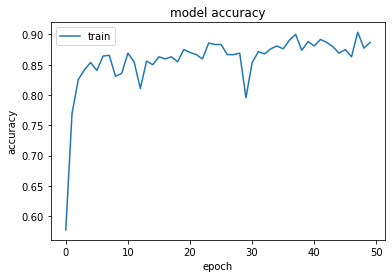

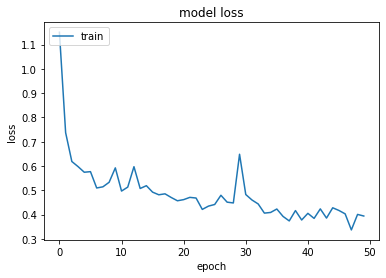

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


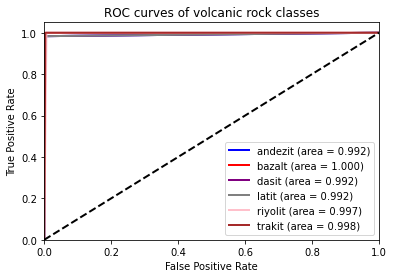

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 59  0  0  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 5
Epoch 1/50
53/53 [==============================] - 19s 189ms/step - loss: 1.4741 - accuracy: 0.4586
Epoch 2/50
53/53 [==============================] - 10s 192ms/step - loss: 0.7709 - accuracy: 0.7524
Epoch 3/50
53/53 [==============================] - 10s 195ms/step - loss: 0.6988 - accuracy: 0.7666
Epoch 4/50
53/53 [==============================] - 10s 195ms/step - loss: 0.6290 - accuracy: 0.8332
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.5397 - accuracy: 0.8534
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.5647 - accuracy: 0.8434
Epoch 7/50
53/53 [==============================] - 10s 189ms/step - loss: 0.5086 - accuracy: 0.8616
Epoch 8/50
53/53 [==============================] - 10s 189ms/step - loss: 0.5503 - accuracy: 0.8463
Epoch 9/50
53/53 [==============================] - 10s 1

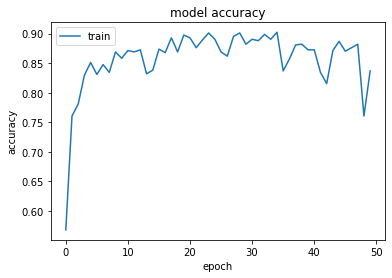

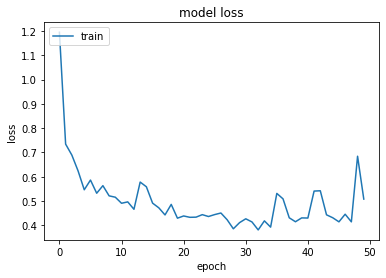

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


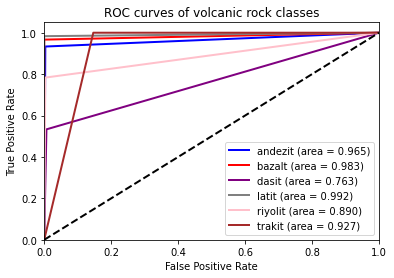

[[56  0  2  0  1  1]
 [ 0 58  0  0  0  2]
 [ 0  0 32  0  0 28]
 [ 0  0  0 59  0  1]
 [ 1  0  0  0 47 12]
 [ 0  0  0  0  0 60]]

number of folds: 6
average test accuracies: 0.963


In [44]:
#Training Process

EPOCHS=50
BATCH_SIZE=16
x_fold=6
#optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-07, decay=0.0)
optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
#optimizer=SGD(lr=0.001, momentum=0.0, nesterov=False)
#optimizer=RMSprop(lr=0.0001, rho=0.9)

metric="accuracy" 
loss="categorical_crossentropy" 
model_checkpoint_callback=keras.callbacks.ModelCheckpoint("bestmodel.h5",save_best_only=True,save_weights_only=True,)
callbacks=[model_checkpoint_callback]

test_accuracies = []

for i in range(x_fold):
  print("fold:", i)
  input_shape=(height, width, 3)
  Transfer_Model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
  #Transfer_Model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
  
  add_model = Sequential()

  add_model.add(Flatten())
  add_model.add(BatchNormalization())
  add_model.add(Dense(16, activation='relu'))
  add_model.add(Dropout(0.50))
  add_model.add(BatchNormalization())
        
  add_model.add(Dense(class_number, activation='softmax'))
  #add_model.add(Tranfer_Model.output)

  model = Model(inputs=Transfer_Model.input, outputs=add_model(Transfer_Model.output))

  model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
  history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
  #predictions
  y_pred= model.predict(X_test)
  y_pred=np.argmax(y_pred,axis=1).astype(np.float32)
  y_pred = keras.utils.to_categorical(y_pred, class_number)

  train_score = model.evaluate(X_train, y_train)
  test_score = model.evaluate(X_test, y_test)
  print(train_score)
  print(test_score)
  test_accuracies.append(test_score[1])

  #Plot accuracy 
  plt.close("all")
  plt.plot(history.history['accuracy'])
  #plt.plot(history.history['val_accuracy'])  
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"acc_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot loss
  plt.close("all")
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_accuracy'])
      
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"loss_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot ROC
  plot_roc(i)
  make_report(i)

print("")
print("number of folds:", i+1)
print("average test accuracies:", round(sum(test_accuracies)/len(test_accuracies), 3))

# 55m

DenseNet121 with RMSprop optimizer, drop rate = 0.5

In [45]:
save_path="../ychen/COMP551/mini4_data/classification_results/DenseNet121_RMSprop_dropRate50/"
print(os.path.isdir(save_path))
if os.path.isdir(save_path)==True:
  print("directory exists")
else:
  os.mkdir(save_path)
  print("new directory was created")

False
new directory was created


In [46]:
print(save_path)

../ychen/COMP551/mini4_data/classification_results/DenseNet121_RMSprop_dropRate50/


fold: 0
Epoch 1/50
53/53 [==============================] - 28s 203ms/step - loss: 1.6390 - accuracy: 0.3695
Epoch 2/50
53/53 [==============================] - 11s 205ms/step - loss: 1.0114 - accuracy: 0.6577
Epoch 3/50
53/53 [==============================] - 11s 202ms/step - loss: 0.7704 - accuracy: 0.7791
Epoch 4/50
53/53 [==============================] - 11s 200ms/step - loss: 0.7344 - accuracy: 0.8098
Epoch 5/50
53/53 [==============================] - 11s 199ms/step - loss: 0.6747 - accuracy: 0.8259
Epoch 6/50
53/53 [==============================] - 11s 198ms/step - loss: 0.7066 - accuracy: 0.8128
Epoch 7/50
53/53 [==============================] - 11s 199ms/step - loss: 0.6870 - accuracy: 0.8365
Epoch 8/50
53/53 [==============================] - 11s 200ms/step - loss: 0.6731 - accuracy: 0.8277
Epoch 9/50
53/53 [==============================] - 11s 201ms/step - loss: 0.6235 - accuracy: 0.8666
Epoch 10/50
53/53 [==============================] - 11s 201ms/step - loss: 0.6274 

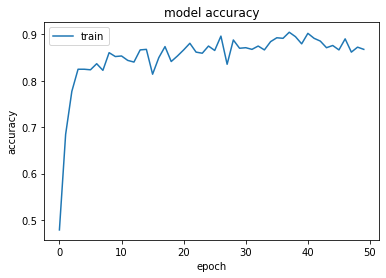

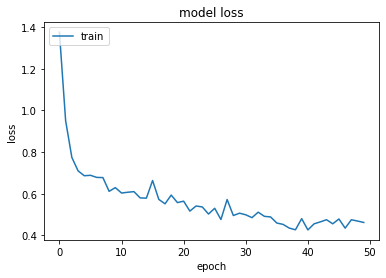

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


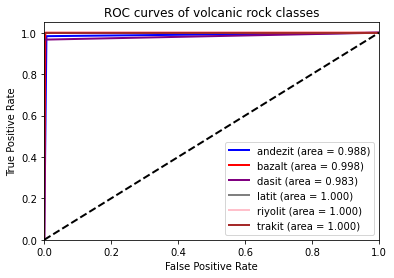

[[59  1  0  0  0  0]
 [ 0 60  0  0  0  0]
 [ 2  0 58  0  0  0]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 1
Epoch 1/50
53/53 [==============================] - 28s 199ms/step - loss: 1.7303 - accuracy: 0.3389
Epoch 2/50
53/53 [==============================] - 11s 202ms/step - loss: 1.0602 - accuracy: 0.6221
Epoch 3/50
53/53 [==============================] - 11s 204ms/step - loss: 0.8846 - accuracy: 0.7397
Epoch 4/50
53/53 [==============================] - 11s 203ms/step - loss: 0.7515 - accuracy: 0.7758
Epoch 5/50
53/53 [==============================] - 11s 201ms/step - loss: 0.7614 - accuracy: 0.7731
Epoch 6/50
53/53 [==============================] - 11s 200ms/step - loss: 0.6903 - accuracy: 0.8349
Epoch 7/50
53/53 [==============================] - 11s 199ms/step - loss: 0.6697 - accuracy: 0.8568
Epoch 8/50
53/53 [==============================] - 11s 199ms/step - loss: 0.6640 - accuracy: 0.8422
Epoch 9/50
53/53 [==============================] - 11s 2

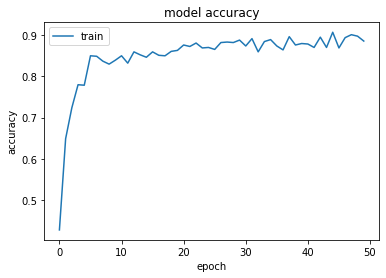

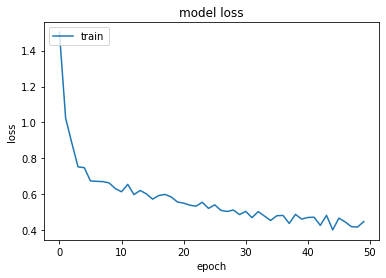

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


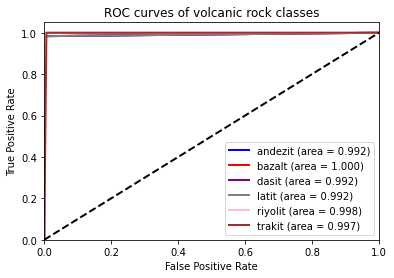

[[59  0  0  0  0  1]
 [ 0 60  0  0  0  0]
 [ 0  0 59  0  0  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 2
Epoch 1/50
53/53 [==============================] - 27s 197ms/step - loss: 1.7196 - accuracy: 0.3425
Epoch 2/50
53/53 [==============================] - 11s 199ms/step - loss: 0.9897 - accuracy: 0.6522
Epoch 3/50
53/53 [==============================] - 11s 202ms/step - loss: 0.8337 - accuracy: 0.7421
Epoch 4/50
53/53 [==============================] - 11s 203ms/step - loss: 0.7132 - accuracy: 0.7987
Epoch 5/50
53/53 [==============================] - 11s 201ms/step - loss: 0.6835 - accuracy: 0.7971
Epoch 6/50
53/53 [==============================] - 11s 199ms/step - loss: 0.6444 - accuracy: 0.8368
Epoch 7/50
53/53 [==============================] - 10s 197ms/step - loss: 0.6277 - accuracy: 0.8302
Epoch 8/50
53/53 [==============================] - 10s 197ms/step - loss: 0.6309 - accuracy: 0.8158
Epoch 9/50
53/53 [==============================] - 10s 1

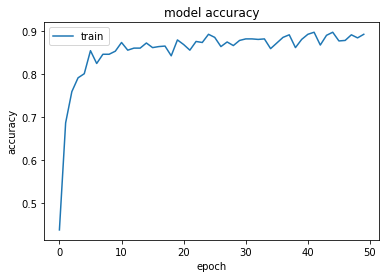

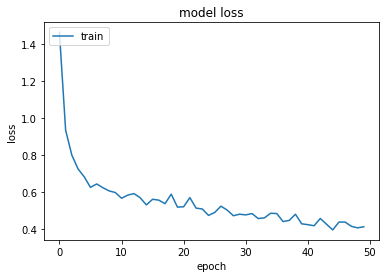

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


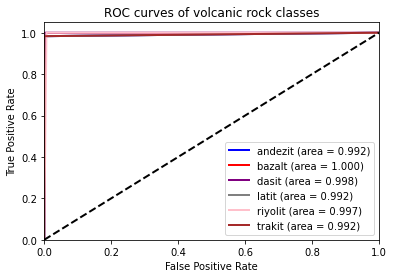

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 60  0  0  0]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  1  0  0 59]]
fold: 3
Epoch 1/50
53/53 [==============================] - 26s 195ms/step - loss: 1.5785 - accuracy: 0.3966
Epoch 2/50
53/53 [==============================] - 11s 199ms/step - loss: 0.8761 - accuracy: 0.7285
Epoch 3/50
53/53 [==============================] - 11s 201ms/step - loss: 0.7813 - accuracy: 0.7875
Epoch 4/50
53/53 [==============================] - 11s 201ms/step - loss: 0.7019 - accuracy: 0.8040
Epoch 5/50
53/53 [==============================] - 11s 199ms/step - loss: 0.6867 - accuracy: 0.8361
Epoch 6/50
53/53 [==============================] - 10s 197ms/step - loss: 0.7090 - accuracy: 0.8048
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 0.6452 - accuracy: 0.8468
Epoch 8/50
53/53 [==============================] - 10s 196ms/step - loss: 0.6549 - accuracy: 0.8488
Epoch 9/50
53/53 [==============================] - 10s 1

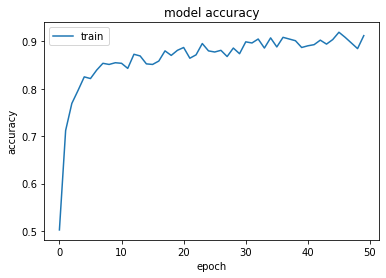

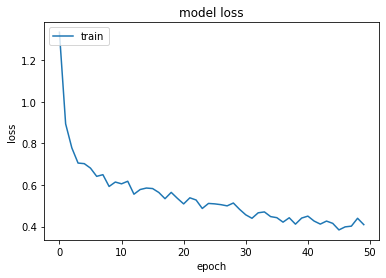

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


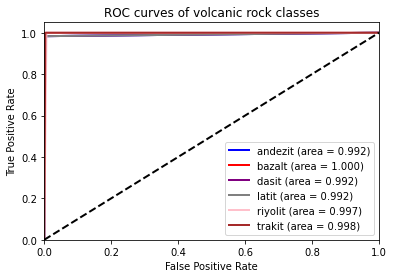

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 59  0  0  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]
fold: 4
Epoch 1/50
53/53 [==============================] - 27s 196ms/step - loss: 1.6313 - accuracy: 0.3516
Epoch 2/50
53/53 [==============================] - 11s 199ms/step - loss: 0.9100 - accuracy: 0.7254
Epoch 3/50
53/53 [==============================] - 11s 201ms/step - loss: 0.8415 - accuracy: 0.7462
Epoch 4/50
53/53 [==============================] - 11s 201ms/step - loss: 0.7367 - accuracy: 0.8000
Epoch 5/50
53/53 [==============================] - 11s 198ms/step - loss: 0.6967 - accuracy: 0.8168
Epoch 6/50
53/53 [==============================] - 10s 197ms/step - loss: 0.7238 - accuracy: 0.8184
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 0.6523 - accuracy: 0.8550
Epoch 8/50
53/53 [==============================] - 10s 196ms/step - loss: 0.6314 - accuracy: 0.8757
Epoch 9/50
53/53 [==============================] - 10s 1

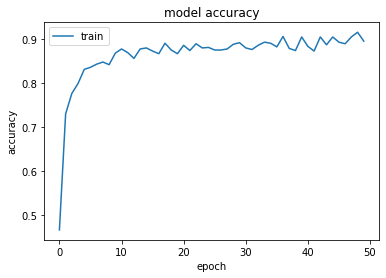

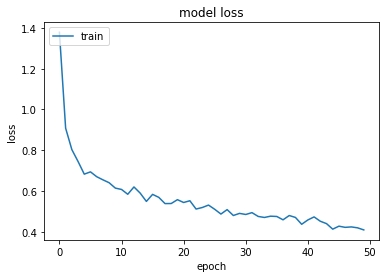

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


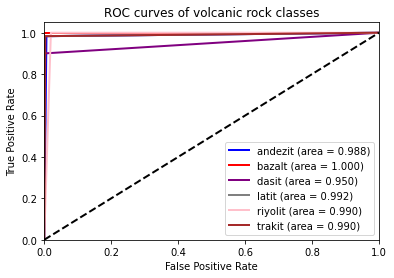

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 2  0 54  0  3  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  1 59]]
fold: 5
Epoch 1/50
53/53 [==============================] - 27s 194ms/step - loss: 1.5339 - accuracy: 0.4213
Epoch 2/50
53/53 [==============================] - 10s 198ms/step - loss: 1.0131 - accuracy: 0.6637
Epoch 3/50
53/53 [==============================] - 11s 201ms/step - loss: 0.8012 - accuracy: 0.7738
Epoch 4/50
53/53 [==============================] - 11s 201ms/step - loss: 0.7687 - accuracy: 0.7833
Epoch 5/50
53/53 [==============================] - 11s 198ms/step - loss: 0.7086 - accuracy: 0.8031
Epoch 6/50
53/53 [==============================] - 10s 196ms/step - loss: 0.6658 - accuracy: 0.8062
Epoch 7/50
53/53 [==============================] - 10s 195ms/step - loss: 0.7047 - accuracy: 0.8019
Epoch 8/50
53/53 [==============================] - 10s 195ms/step - loss: 0.6505 - accuracy: 0.8289
Epoch 9/50
53/53 [==============================] - 10s 1

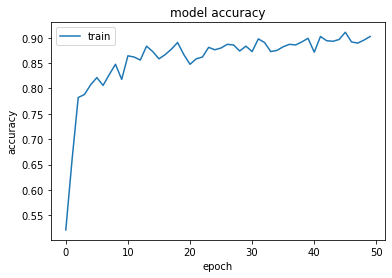

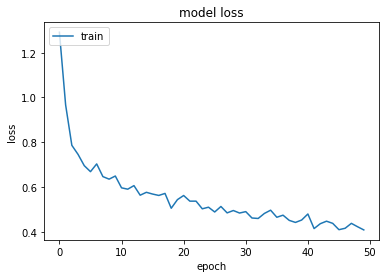

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


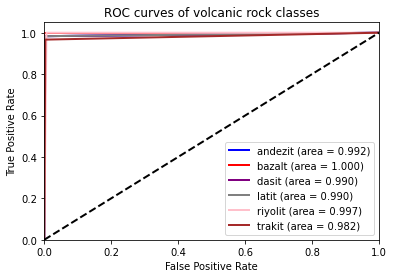

[[59  0  0  0  1  0]
 [ 0 60  0  0  0  0]
 [ 0  0 59  0  0  1]
 [ 0  0  0 59  1  0]
 [ 0  0  0  0 60  0]
 [ 0  0  1  1  0 58]]

number of folds: 6
average test accuracies: 0.988


In [47]:
#Training Process

EPOCHS=50
BATCH_SIZE=16
x_fold=6
#optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-07, decay=0.0)
#optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
#optimizer=SGD(lr=0.001, momentum=0.0, nesterov=False)
optimizer=RMSprop(lr=0.0001, rho=0.9)

metric="accuracy" 
loss="categorical_crossentropy" 
model_checkpoint_callback=keras.callbacks.ModelCheckpoint("bestmodel.h5",save_best_only=True,save_weights_only=True,)
callbacks=[model_checkpoint_callback]

test_accuracies = []

for i in range(x_fold):
  print("fold:", i)
  input_shape=(height, width, 3)
  Transfer_Model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
  #Transfer_Model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
  
  add_model = Sequential()

  add_model.add(Flatten())
  add_model.add(BatchNormalization())
  add_model.add(Dense(16, activation='relu'))
  add_model.add(Dropout(0.50))
  add_model.add(BatchNormalization())
        
  add_model.add(Dense(class_number, activation='softmax'))
  #add_model.add(Tranfer_Model.output)

  model = Model(inputs=Transfer_Model.input, outputs=add_model(Transfer_Model.output))

  model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
  history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
  #predictions
  y_pred= model.predict(X_test)
  y_pred=np.argmax(y_pred,axis=1).astype(np.float32)
  y_pred = keras.utils.to_categorical(y_pred, class_number)

  train_score = model.evaluate(X_train, y_train)
  test_score = model.evaluate(X_test, y_test)
  print(train_score)
  print(test_score)
  test_accuracies.append(test_score[1])

  #Plot accuracy 
  plt.close("all")
  plt.plot(history.history['accuracy'])
  #plt.plot(history.history['val_accuracy'])  
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"acc_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot loss
  plt.close("all")
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_accuracy'])
      
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(os.path.join(save_path,"loss_"+str(i)+".jpg"),dpi=150)
  plt.show()
  
  #Plot ROC
  plot_roc(i)
  make_report(i)

print("")
print("number of folds:", i+1)
print("average test accuracies:", round(sum(test_accuracies)/len(test_accuracies), 3))

# 55m23s